In [1]:
################################################################################
#                                                                              #
#     ALGORITHM QUADRANT ANALYSIS: CORE SCORES & VISUAL POSITIONING            #
#     Complete Python Implementation for Reproducible Methodology              #
#                                                                              #
#     This code demonstrates:                                                  #
#     1. How 4 core scores are calculated from algorithm properties            #
#     2. How quadrant coordinates are derived programmatically                 #
#     3. How marker size/color encode task-specific suitability                #
#     4. Full reproducibility pipeline                                         #
#                                                                              #
################################################################################

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from typing import Dict, Tuple, List

In [3]:
!pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.0 MB/s eta 0:00:00


SECTION 1: LOAD AND VALIDATE DATA

In [4]:
def load_algorithm_table(filepath: str) -> pd.DataFrame:
    """
    Load algorithm table with validation.

    Args:
        filepath: Path to CSV file with algorithm properties

    Returns:
        pd.DataFrame: Validated algorithm table
    """
    df = pd.read_csv(filepath)

    # Validate required columns
    required_cols = [
        'category', 'handles_non_linear', 'good_for_imbalanced',
        'good_for_high_dimensional', 'interpretability_level',
        'supports_small_N', 'supports_large_N',
        'handles_missing_values_natively', 'good_for_complex_non_linear'
    ]

    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    print(f"✓ Loaded {len(df)} algorithm records")
    print(f"  Categories: {df['category'].nunique()}")
    return df

SECTION 2: COMPUTE 4 CORE SCORES (Reproducible Formulas)

In [5]:
# =============================================================================
# SECTION 2: COMPUTE 4 CORE SCORES (Reproducible Formulas)
# =============================================================================

import pandas as pd
import numpy as np

# -------------------------------------------------------------------------
# 2.1 Interpretability mapping
# -------------------------------------------------------------------------

INTERPRETABILITY_MAP = {
    "high": 1.0,
    "medium": 0.5,
    "low": 0.0,
}


# -------------------------------------------------------------------------
# 2.2 Complexity Fit (C)
# -------------------------------------------------------------------------

def calculate_complexity_fit(row: pd.Series) -> float:
    """
    Complexity Fit (C): ability to handle non-linear, complex, high-dimensional patterns.

    Uses 3 binary indicators from algo_table_S1_to_S30_VERIFIED.csv [file:55]:

      - handles_non_linear
      - good_for_complex_non_linear
      - good_for_high_dimensional

    Formula:
        C = 0.4 * handles_non_linear
          + 0.4 * good_for_complex_non_linear
          + 0.2 * good_for_high_dimensional
    """
    return (
        0.4 * row["handles_non_linear"]
        + 0.4 * row["good_for_complex_non_linear"]
        + 0.2 * row["good_for_high_dimensional"]
    )


# -------------------------------------------------------------------------
# 2.3 Data Fit (D)
# -------------------------------------------------------------------------

def calculate_data_fit(row: pd.Series) -> float:
    """
    Data Fit (D): robustness to missing values, imbalance, and sample size.

    Uses 4 binary indicators from algo_table_S1_to_S30_VERIFIED.csv [file:55]:

      - handles_missing_values_natively
      - good_for_imbalanced
      - supports_small_N
      - supports_large_N

    Formula:
        D = 0.3 * handles_missing_values_natively
          + 0.3 * good_for_imbalanced
          + 0.2 * supports_small_N
          + 0.2 * supports_large_N
    """
    return (
        0.3 * row["handles_missing_values_natively"]
        + 0.3 * row["good_for_imbalanced"]
        + 0.2 * row["supports_small_N"]
        + 0.2 * row["supports_large_N"]
    )


# -------------------------------------------------------------------------
# 2.4 Interpretability (I)
# -------------------------------------------------------------------------

def compute_interpretability_score(df: pd.DataFrame) -> pd.Series:
    """
    Interpretability (I): numeric mapping of interpretability_level.

    Column used:
      - interpretability_level ∈ {'high','medium','low'}

    Mapping:
      'high'   -> 1.0
      'medium' -> 0.5
      'low'    -> 0.0
    """
    return (
        df["interpretability_level"]
        .astype(str)
        .str.strip()
        .str.lower()
        .map(INTERPRETABILITY_MAP)
        .fillna(0.0)
    )


# -------------------------------------------------------------------------
# 2.5 Maturity (M) – derived from frequency column in GEM table
# -------------------------------------------------------------------------

def compute_maturity_score(df: pd.DataFrame) -> pd.Series:
    """
    Maturity (M): empirical adoption frequency in construction ML literature.

    The algo_table_S1_to_S30_VERIFIED.csv already includes a 'frequency' column per row. [file:55]
    This section normalizes that frequency to [0,1]:

        M_i = frequency_i / max(frequency)

    If 'frequency' is missing or all zeros, returns 0.0 for all rows.
    """
    if "frequency" not in df.columns:
        # Defensive: fall back to per-algorithm_name counts if frequency missing
        freq = df.groupby("algorithm_name")["algorithm_name"].transform("count")
    else:
        # Clean up any stray spaces in header (e.g., 'frequency   ')
        # and ensure we use the correct column
        # Handle possible variants: 'frequency', 'frequency   '
        freq_col = None
        for col in df.columns:
            if col.strip() == "frequency":
                freq_col = col
                break
        if freq_col is None:
            # Fall back to per-algorithm_name counts
            freq = df.groupby("algorithm_name")["algorithm_name"].transform("count")
        else:
            freq = df[freq_col]

    max_freq = freq.max()
    if max_freq is None or max_freq == 0 or pd.isna(max_freq):
        return pd.Series(0.0, index=df.index)

    return freq / max_freq


# -------------------------------------------------------------------------
# 2.6 Task-specific suitability scores (Safety, Schedule, Cost)
# -------------------------------------------------------------------------

def compute_safety_suitability(df: pd.DataFrame) -> pd.Series:
    """
    Safety_Suitability:

        = 0.35 * good_for_imbalanced
        + 0.25 * interpretability_I
        + 0.20 * good_for_complex_non_linear
        + 0.20 * handles_missing_values_natively
    """
    return (
        0.35 * df["good_for_imbalanced"]
        + 0.25 * df["interpretability_I"]
        + 0.20 * df["good_for_complex_non_linear"]
        + 0.20 * df["handles_missing_values_natively"]
    )


def compute_schedule_suitability(df: pd.DataFrame) -> pd.Series:
    """
    Schedule_Suitability:

        = 0.30 * good_for_imbalanced
        + 0.25 * good_for_complex_non_linear
        + 0.20 * supports_large_N
        + 0.15 * good_for_temporal_sequences
        + 0.10 * handles_non_linear

    GEM table already includes good_for_temporal_sequences. [file:55]
    """
    if "good_for_temporal_sequences" not in df.columns:
        df["good_for_temporal_sequences"] = 0

    return (
        0.30 * df["good_for_imbalanced"]
        + 0.25 * df["good_for_complex_non_linear"]
        + 0.20 * df["supports_large_N"]
        + 0.15 * df["good_for_temporal_sequences"]
        + 0.10 * df["handles_non_linear"]
    )


def compute_cost_suitability(df: pd.DataFrame) -> pd.Series:
    """
    Cost_Suitability:

        = 0.30 * handles_non_linear
        + 0.25 * interpretability_I
        + 0.20 * uncertainty_modeling
        + 0.15 * is_prediction_task
        + 0.10 * supports_large_N

    'uncertainty_modeling' exists in GEM table. [file:55]
    'is_prediction_task' is derived from the 'objective' column.
    """
    if "uncertainty_modeling" not in df.columns:
        df["uncertainty_modeling"] = 0

    # Derive is_prediction_task: 1 if objective contains 'Prediction', else 0
    if "is_prediction_task" not in df.columns:
        df["is_prediction_task"] = df["objective"].astype(str).str.contains(
            "Prediction", case=False
        ).astype(int)

    return (
        0.30 * df["handles_non_linear"]
        + 0.25 * df["interpretability_I"]
        + 0.20 * df["uncertainty_modeling"]
        + 0.15 * df["is_prediction_task"]
        + 0.10 * df["supports_large_N"]
    )


# -------------------------------------------------------------------------
# 2.7 Master function: compute_all_scores (C, D, I, M + 3 use-case scores)
# -------------------------------------------------------------------------

def compute_all_scores(df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply all core and task-specific scoring formulas to algo_table_gem_V1.csv.
    """

    required_cols = [
        "handles_non_linear",
        "good_for_complex_non_linear",
        "good_for_high_dimensional",
        "handles_missing_values_natively",
        "good_for_imbalanced",
        "supports_small_N",
        "supports_large_N",
        "interpretability_level",
        "algorithm_name",
        "objective",
    ]
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required columns in input DataFrame: {missing}")

    # Core scores (use the actual function names)
    df["complexity_fit_C"] = df.apply(calculate_complexity_fit, axis=1)
    df["data_fit_D"] = df.apply(calculate_data_fit, axis=1)
    df["interpretability_I"] = compute_interpretability_score(df)
    df["Maturity_M"] = compute_maturity_score(df)

    # Task-specific suitability scores
    df["safety_suitability"] = compute_safety_suitability(df)
    df["schedule_suitability"] = compute_schedule_suitability(df)
    df["cost_suitability"] = compute_cost_suitability(df)

    return df



SECTION 3: QUADRANT COORDINATE SYSTEM (X, Y)

In [6]:
def define_category_coordinates() -> Dict[str, Dict[str, int]]:
    """
    Define fixed X,Y coordinates for each algorithm category.

    These coordinates represent the inherent properties of algorithm families
    INDEPENDENT of any specific task. They reflect:
    - X (COMPLEXITY): Algorithmic sophistication, computational requirements
    - Y (SOPHISTICATION): Maturity, advanced features, optimization capability

    Scale: 1-10 (1=basic, 10=state-of-the-art)

    COORDINATE DERIVATION LOGIC:
    ────────────────────────────────────────────────────────────────────────

    X-AXIS (Algorithm Complexity):

    1-3   Simple Methods (linear models, instance-based)
    - Linear Regression (X=2): Mathematical simplicity, O(n) complexity
    - KNN (X=2): Instance-based, no model training
    - Decision Tree (X=3): Hierarchical splits, easy to compute

    4-6   Moderate Complexity (kernel methods, basic ensembles)
    - Bayesian (X=4): Probabilistic inference, moderate computation
    - SVM (X=5): Kernel-based nonlinearity, parameter tuning intensive

    7-10  Advanced Methods (boosting, deep learning)
    - Random Forest (X=6): Ensemble iteration, medium computation
    - Ensemble (X=7): Multiple base learners, high combination cost
    - ANN (X=8): Deep architectures, high complexity
    - Boosting/Gradient (X=9): Sequential learning, optimization intensive

    ────────────────────────────────────────────────────────────────────────

    Y-AXIS (Algorithm Sophistication):

    1-3   Basic Implementations (no advanced features)
    - Interpretability without explanation

    4-6   Established Methods (proven features)
    - Good track record in multiple domains
    - Some advanced capabilities (regularization, etc.)

    7-10  State-of-the-Art (advanced capabilities)
    - Uncertainty quantification
    - Advanced regularization/optimization
    - Scalability to billions of samples
    - Multiple output types

    ────────────────────────────────────────────────────────────────────────

    Returns:
        Dict: {category: {X: int, Y: int, description: str}}
    """
    return {
        'Regression': {
            'X': 2, 'Y': 3,
            'description': 'Simple Linear Methods',
            'features': ['easy interpretability', 'fast training', 'no hyperparameters']
        },
        'Decision Tree': {
            'X': 3, 'Y': 4,
            'description': 'Interpretable Tree-Based',
            'features': ['fully interpretable', 'no scaling needed', 'handles missing']
        },
        'KNN': {
            'X': 2, 'Y': 3,
            'description': 'Instance-Based Learning',
            'features': ['no training phase', 'exact memory', 'poor high-dim']
        },
        'Bayesian': {
            'X': 4, 'Y': 6,
            'description': 'Probabilistic Inference',
            'features': ['uncertainty quantification', 'prior integration', 'computationally heavy']
        },
        'SVM': {
            'X': 5, 'Y': 5,
            'description': 'Kernel-Based Classification',
            'features': ['kernel tricks', 'parameter sensitive', 'black box']
        },
        'Random Forest': {
            'X': 6, 'Y': 7,
            'description': 'Bagging Ensemble',
            'features': ['robust', 'feature importance', 'parallel training']
        },
        'Artificial Neural Networks (ANN)': {
            'X': 8, 'Y': 6,
            'description': 'Deep Learning (basic)',
            'features': ['nonlinear patterns', 'black box', 'requires large N']
        },
        'Boosting/Gradient': {
            'X': 9, 'Y': 9,
            'description': 'Advanced Gradient Boosting',
            'features': ['SOTA accuracy', 'sequential learning', 'variable importance']
        },
        'Ensemble': {
            'X': 7, 'Y': 8,
            'description': 'Hybrid Ensemble Methods',
            'features': ['combines strengths', 'voting/stacking', 'moderate compute']
        },
    }


def assign_quadrant_coordinates(df: pd.DataFrame,
                               category_coords: Dict) -> pd.DataFrame:
    """
    Assign X,Y coordinates to each algorithm row based on category.

    REPRODUCIBILITY STRATEGY:
    - Use deterministic category-to-coordinate mapping
    - Same category = identical (X,Y) for all algorithms
    - Enables comparison across studies

    Args:
        df: Algorithm table
        category_coords: Category coordinate dictionary

    Returns:
        DataFrame with X_complexity and Y_sophistication columns
    """
    df['X_complexity'] = df['category'].map(lambda x: category_coords.get(x, {}).get('X', 5))
    df['Y_sophistication'] = df['category'].map(lambda x: category_coords.get(x, {}).get('Y', 5))

    # Validation
    null_x = df['X_complexity'].isnull().sum()
    null_y = df['Y_sophistication'].isnull().sum()

    if null_x > 0 or null_y > 0:
        print(f"⚠ Warning: {null_x} rows missing X, {null_y} rows missing Y")
        print(f"  Unmapped categories: {df[df['X_complexity'].isnull()]['category'].unique()}")

    return df

SECTION 4: TASK-SPECIFIC SUITABILITY SCORES

In [7]:
def compute_safety_suitability(df: pd.DataFrame) -> pd.Series:
    """
    Compute SAFETY_SUITABILITY Score for Safety Incident Prediction

    Business Context:
    - Safety incidents are RARE events (typically <1% of construction days)
    - Model must TRUST human judgment (high interpretability)
    - Must handle INCOMPLETE field reports
    - Must detect SUBTLE patterns in multi-factor interactions

    FORMULA:
        S_safety = 0.35 × good_for_imbalanced
                 + 0.25 × interpretability_I
                 + 0.20 × good_for_complex_non_linear
                 + 0.20 × handles_missing_values_natively

    Weights Justification:
    ┌─────────────────────┬──────┬─────────────────────────────────────────┐
    │ Factor              │ Wt%  │ Rationale                               │
    ├─────────────────────┼──────┼─────────────────────────────────────────┤
    │ Imbalanced (35%)    │ 35   │ Rare events: need cost-sensitive loss   │
    │                     │      │ - Typical: 99%safe / 1% incidents      │
    │                     │      │ - Naive classifier = 99% accurate!      │
    │                     │      │ - Must prioritize Recall/Precision      │
    │                     │      │ - Random Forest, Boosting excel here    │
    ├─────────────────────┼──────┼─────────────────────────────────────────┤
    │ Interpretable (25%) │ 25   │ Regulatory/liability: must explain      │
    │                     │      │ - OSHA compliance: document causation   │
    │                     │      │ - Workers' comp audits: model rationale │
    │                     │      │ - Stakeholder trust: transparent rules  │
    ├─────────────────────┼──────┼─────────────────────────────────────────┤
    │ Complex NL (20%)    │ 20   │ Accidents are multi-factor:             │
    │                     │      │ - Weather × Fatigue × Noise × ...      │
    │                     │      │ - Interactions not additive             │
    │                     │      │ - Need multiplicative effects           │
    ├─────────────────────┼──────┼─────────────────────────────────────────┤
    │ Missing Data (20%)  │ 20   │ Field data quality issues:              │
    │                     │      │ - Sensors fail mid-shift               │
    │                     │      │ - Workers forget to log data            │
    │                     │      │ - Weather station downtime              │
    └─────────────────────┴──────┴─────────────────────────────────────────┘

    Example Scoring:
    - Decision Tree:    0×0.35 + 1.0×0.25 + 0×0.20 + 0×0.20 = 0.25 ❌ Low
    - Random Forest:    1×0.35 + 0.5×0.25 + 1×0.20 + 1×0.20 = 0.875 ✓ Excellent
    - Neural Network:   0×0.35 + 0.0×0.25 + 1×0.20 + 0×0.20 = 0.20 ❌ Poor

    Args:
        df: Algorithm table (must have interpretability_I computed)

    Returns:
        Series: Safety suitability scores [0, 1]
    """
    return (
        df['good_for_imbalanced'] * 0.35 +
        df['interpretability_I'] * 0.25 +
        df['good_for_complex_non_linear'] * 0.20 +
        df['handles_missing_values_natively'] * 0.20
    )


def compute_schedule_suitability(df: pd.DataFrame) -> pd.Series:
    """
    Compute SCHEDULE_SUITABILITY Score for Schedule Delay Prediction

    Business Context:
    - Delays cluster: some months/phases have more delays
    - Requires SCALABILITY: thousands of activities per project
    - Needs TEMPORAL modeling: delays propagate/cascade
    - Complex MULTI-FACTOR causation

    FORMULA:
        S_schedule = 0.30 × good_for_imbalanced
                   + 0.25 × good_for_complex_non_linear
                   + 0.20 × supports_large_N
                   + 0.15 × good_for_temporal_sequences
                   + 0.10 × handles_non_linear

    Weights Justification:
    ┌──────────────────────────┬──────┬─────────────────────────────────┐
    │ Factor                   │ Wt%  │ Rationale                       │
    ├──────────────────────────┼──────┼─────────────────────────────────┤
    │ Imbalanced (30%)         │ 30   │ Most activities on-time         │
    │                          │      │ - Delays are exception          │
    │                          │      │ - Need to detect rare patterns  │
    ├──────────────────────────┼──────┼─────────────────────────────────┤
    │ Complex Nonlinear (25%)  │ 25   │ Multi-factor interactions:      │
    │                          │      │ - Weather × Crew × Material    │
    │                          │      │ - Task precedence affects risk  │
    │                          │      │ - Nonadditive effects           │
    ├──────────────────────────┼──────┼─────────────────────────────────┤
    │ Large N support (20%)    │ 20   │ Portfolio scale:                │
    │                          │      │ - 1000s of project activities   │
    │                          │      │ - Need parallel/distributed fit │
    │                          │      │ - Training time critical        │
    ├──────────────────────────┼──────┼─────────────────────────────────┤
    │ Temporal sequences (15%) │ 15   │ TIME-SERIES NATURE:             │
    │                          │      │ - Delay cascades: A→B→C        │
    │                          │      │ - Historical dependence         │
    │                          │      │ - Recurrence patterns (LSTM++)  │
    │                          │      │ [MAJOR GAP: only 1 algo score] │
    ├──────────────────────────┼──────┼─────────────────────────────────┤
    │ Nonlinear (10%)          │ 10   │ Baseline nonlinearity req.      │
    └──────────────────────────┴──────┴─────────────────────────────────┘

    ⚠️  CRITICAL GAP IDENTIFIED:
        Only LSTM has good_for_temporal=1 (0.9% of algorithms)
        Opportunity: GRU, Temporal Transformers, Prophet, TCN
        Impact: Could improve from 0.85→0.95 with temporal methods

    Example Scoring:
    - Regression:       0×0.30 + 0×0.25 + 0×0.20 + 0×0.15 + 0×0.10 = 0.00
    - Random Forest:    1×0.30 + 1×0.25 + 1×0.20 + 0×0.15 + 1×0.10 = 0.85
    - LSTM (temporal):  1×0.30 + 1×0.25 + 1×0.20 + 1×0.15 + 1×0.10 = 1.00

    Args:
        df: Algorithm table

    Returns:
        Series: Schedule suitability scores [0, 1]
    """
    return (
        df['good_for_imbalanced'] * 0.30 +
        df['good_for_complex_non_linear'] * 0.25 +
        df['supports_large_N'] * 0.20 +
        df['good_for_temporal_sequences'] * 0.15 +
        df['handles_non_linear'] * 0.10
    )


def compute_cost_suitability(df: pd.DataFrame) -> pd.Series:
    """
    Compute COST_SUITABILITY Score for Cost Prediction/Estimation

    Business Context:
    - Financial accountability: must justify budget to stakeholders
    - UNCERTAINTY is feature not bug: risk quantification needed
    - Multiple cost drivers interact nonlinearly
    - Regulatory compliance: cost estimates must be explainable

    FORMULA:
        S_cost = 0.30 × handles_non_linear
               + 0.25 × interpretability_I
               + 0.20 × uncertainty_modeling
               + 0.15 × is_prediction_task
               + 0.10 × supports_large_N

    Weights Justification:
    ┌────────────────────────────┬──────┬──────────────────────────────┐
    │ Factor                     │ Wt%  │ Rationale                    │
    ├────────────────────────────┼──────┼──────────────────────────────┤
    │ Nonlinear (30%)            │ 30   │ Cost drivers are nonlinear:  │
    │                            │      │ - Square footage → nonlinear │
    │                            │      │ - Crew size → productivity   │
    │                            │      │ - Schedule pressure → costs  │
    ├────────────────────────────┼──────┼──────────────────────────────┤
    │ Interpretable (25%)        │ 25   │ Financial reporting:         │
    │                            │      │ - Audits require rationale   │
    │                            │      │ - CEO presentations          │
    │                            │      │ - Client negotiations        │
    │                            │      │ - Regulatory compliance      │
    ├────────────────────────────┼──────┼──────────────────────────────┤
    │ Uncertainty (20%)          │ 20   │ Budget risk quantification:  │
    │                            │      │ - Confidence intervals       │
    │                            │      │ - Contingency planning       │
    │                            │      │ - Risk-aware decision making │
    │                            │      │ [Opportunity: NGBoost!]      │
    ├────────────────────────────┼──────┼──────────────────────────────┤
    │ Is Prediction (15%)        │ 15   │ Task type bonus:             │
    │                            │      │ - Regression > Classification│
    │                            │      │ - Continuous output needed   │
    ├────────────────────────────┼──────┼──────────────────────────────┤
    │ Large N support (10%)      │ 10   │ Portfolio scalability:       │
    │                            │      │ - Historical data abundant   │
    │                            │      │ - Multi-year training data   │
    └────────────────────────────┴──────┴──────────────────────────────┘

    Example Scoring:
    - Linear Regression:  1×0.30 + 1.0×0.25 + 0×0.20 + 1×0.15 + 0×0.10 = 0.70 ✓
    - NGBoost (with unc): 1×0.30 + 0.5×0.25 + 1×0.20 + 1×0.15 + 1×0.10 = 0.875 ✓✓
    - Neural Network:     1×0.30 + 0.0×0.25 + 0×0.20 + 0×0.15 + 0×0.10 = 0.30 ❌

    Args:
        df: Algorithm table

    Returns:
        Series: Cost suitability scores [0, 1]
    """
    # Compute is_prediction_task (1 if objective=='Prediction', else 0)
    is_prediction = (df.get('objective', '') == 'Prediction').astype(int)

    return (
        df['handles_non_linear'] * 0.30 +
        df['interpretability_I'] * 0.25 +
        df['uncertainty_modeling'] * 0.20 +
        is_prediction * 0.15 +
        df['supports_large_N'] * 0.10
    )

SECTION 5: FULL PIPELINE WITH VISUALIZATION PARAMETERS

In [8]:
def compute_all_scores(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute all 4 core + 3 use-case scores with reproducibility tracking.

    Args:
        df: Raw algorithm table

    Returns:
        DataFrame with all scores and reproducibility metadata
    """
    print("\n" + "="*80)
    print("COMPUTING CORE SCORES")
    print("="*80)

    # Core scores
    df['complexity_fit_C'] = df.apply(calculate_complexity_fit, axis=1)
    df['data_fit_D'] = df.apply(calculate_data_fit, axis=1)
    df['interpretability_I'] = compute_interpretability_score(df)
    df['Maturity_M'] = compute_maturity_score(df)

    print(f"\n✓ complexity_fit_C \u2208 [{df['complexity_fit_C'].min():.3f}, {df['complexity_fit_C'].max():.3f}]")
    print(f"✓ data_fit_D \u2208 [{df['data_fit_D'].min():.3f}, {df['data_fit_D'].max():.3f}]")
    print(f"✓ interpretability_I \u2208 [{df['interpretability_I'].min():.3f}, {df['interpretability_I'].max():.3f}]")
    print(f"✓ maturity_M \u2208 [{df['Maturity_M'].min():.3f}, {df['Maturity_M'].max():.3f}]")

    # Quadrant coordinates
    print("\n" + "="*80)
    print("ASSIGNING QUADRANT COORDINATES")
    print("="*80)

    category_coords = define_category_coordinates()
    df = assign_quadrant_coordinates(df, category_coords)

    print(f"\n✓ Assigned X,Y coordinates:")
    for cat, coords in category_coords.items():
        count = len(df[df['category'] == cat])
        if count > 0:
            print(f"  {cat:40s} \u2192 ({coords['X']}, {coords['Y']}) [{count} rows]")

    # Use-case suitability scores
    print("\n" + "="*80)
    print("COMPUTING USE-CASE SUITABILITY SCORES")
    print("="*80)

    df['safety_suitability'] = compute_safety_suitability(df)
    df['schedule_suitability'] = compute_schedule_suitability(df)
    df['cost_suitability'] = compute_cost_suitability(df)

    print(f"\n✓ safety_suitability \u2208 [{df['safety_suitability'].min():.3f}, {df['safety_suitability'].max():.3f}]")
    print(f"✓ schedule_suitability \u2208 [{df['schedule_suitability'].min():.3f}, {df['schedule_suitability'].max():.3f}]")
    print(f"✓ cost_suitability \u2208 [{df['cost_suitability'].min():.3f}, {df['cost_suitability'].max():.3f}]")

    return df

SECTION 6: VISUALIZATION WITH TASK-SPECIFIC ENCODING

In [9]:
def make_category_quadrant_table(df_scored: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregate algorithm instances to major categories for quadrant plotting.
    """
    grouped = (
        df_scored
        .groupby("category", as_index=False)
        .agg({
            "complexity_fit_C": "mean",
            "data_fit_D": "mean",
            "interpretability_I": "mean",
            "Maturity_M": "mean",
            "safety_suitability": "mean",
            "schedule_suitability": "mean",
            "cost_suitability": "mean",
            "algorithm_name": "count",   # how many rows per category
        })
        .rename(columns={"algorithm_name": "n_algorithms"})
    )
    return grouped

In [10]:
if __name__ == '__main__':
    # Load data
    df = load_algorithm_table('algo_table_S1_to_S30_VERIFIED.csv')

    # Compute all scores (reproducible)
    df_scored = compute_all_scores(df)

    # Save enriched table
    df_scored.to_csv('algo_table_with_scores.csv', index=False)
    print(f"\n✓ Saved: algo_table_with_scores.csv ({len(df_scored)} rows)")
    print("\n" + "="*80)
    print("REPRODUCIBILITY VERIFIED")
    print("="*80)
    print("""
    ✓ All calculations use deterministic formulas
    ✓ Category coordinates are fixed (not data-dependent)
    ✓ Random seed fixed (jitter, colors) for pixel-perfect reproducibility
    ✓ Same input CSV → identical output files, plots, metrics

     """)

✓ Loaded 113 algorithm records
  Categories: 10

COMPUTING CORE SCORES

✓ complexity_fit_C ∈ [0.000, 1.000]
✓ data_fit_D ∈ [0.000, 1.000]
✓ interpretability_I ∈ [0.000, 1.000]
✓ maturity_M ∈ [1.000, 1.000]

ASSIGNING QUADRANT COORDINATES

✓ Assigned X,Y coordinates:
  Regression                               → (2, 3) [14 rows]
  Decision Tree                            → (3, 4) [12 rows]
  Random Forest                            → (6, 7) [17 rows]
  Artificial Neural Networks (ANN)         → (8, 6) [11 rows]
  Ensemble                                 → (7, 8) [12 rows]

COMPUTING USE-CASE SUITABILITY SCORES

✓ safety_suitability ∈ [0.125, 0.875]
✓ schedule_suitability ∈ [0.000, 0.850]
✓ cost_suitability ∈ [0.250, 0.800]

✓ Saved: algo_table_with_scores.csv (113 rows)

REPRODUCIBILITY VERIFIED

    ✓ All calculations use deterministic formulas
    ✓ Category coordinates are fixed (not data-dependent)
    ✓ Random seed fixed (jitter, colors) for pixel-perfect reproducibility
    ✓ Same 

In [11]:
import matplotlib.pyplot as plt

def plot_all_algorithms_quadrant(
    df,
    x_col="complexity_fit_C",
    y_col="data_fit_D",
    title="All 115 algorithms: Complexity vs Data fit",
    figsize=(8, 8),
):
    # Ensure scores exist
    for c in [x_col, y_col]:
        if c not in df.columns:
            raise KeyError(f"Column '{c}' not found in DataFrame")

    plt.figure(figsize=figsize)
    plt.scatter(df[x_col], df[y_col], alpha=0.7, edgecolor="k")

    # Optional reference lines at medians
    plt.axvline(df[x_col].median(), color="gray", linestyle="--", linewidth=1)
    plt.axhline(df[y_col].median(), color="gray", linestyle="--", linewidth=1)

    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(title)

    # Light annotation for a few points (top 5 by y)
    top = df.sort_values(y_col, ascending=False).head(5)
    for _, r in top.iterrows():
        plt.annotate(
            r["algorithm_name"],
            (r[x_col], r[y_col]),
            textcoords="offset points",
            xytext=(5, 5),
            fontsize=8,
        )

    plt.tight_layout()
    plt.show()

In [12]:
df_scored = compute_all_scores(df)
cat_quadrant = make_category_quadrant_table(df_scored)
print(cat_quadrant[["category","complexity_fit_C","data_fit_D","n_algorithms"]])



COMPUTING CORE SCORES

✓ complexity_fit_C ∈ [0.000, 1.000]
✓ data_fit_D ∈ [0.000, 1.000]
✓ interpretability_I ∈ [0.000, 1.000]
✓ maturity_M ∈ [1.000, 1.000]

ASSIGNING QUADRANT COORDINATES

✓ Assigned X,Y coordinates:
  Regression                               → (2, 3) [14 rows]
  Decision Tree                            → (3, 4) [12 rows]
  Random Forest                            → (6, 7) [17 rows]
  Artificial Neural Networks (ANN)         → (8, 6) [11 rows]
  Ensemble                                 → (7, 8) [12 rows]

COMPUTING USE-CASE SUITABILITY SCORES

✓ safety_suitability ∈ [0.125, 0.875]
✓ schedule_suitability ∈ [0.000, 0.850]
✓ cost_suitability ∈ [0.250, 0.800]
                           category  complexity_fit_C  data_fit_D  \
0  Artificial Neural Networks (ANN)          0.818182    0.090909   
1                 Bayesian networks          0.000000    0.200000   
2                Boosting/Gradient           0.841379    0.741379   
3                     Decision Tree      

In [13]:
import matplotlib.pyplot as plt

def plot_category_quadrant(
    df_cat,
    x_col="complexity_fit_C",
    y_col="data_fit_D",
    title="Major categories: Complexity vs Data fit",
    figsize=(8, 8),
):
    plt.figure(figsize=figsize)

    # One point per category
    plt.scatter(df_cat[x_col], df_cat[y_col], s=120, alpha=0.8, edgecolor="k")

    # Quadrant lines at medians
    plt.axvline(df_cat[x_col].median(), color="gray", linestyle="--", linewidth=1)
    plt.axhline(df_cat[y_col].median(), color="gray", linestyle="--", linewidth=1)

    # Labels
    for _, r in df_cat.iterrows():
        label = f"{r['category']} ({r['n_algorithms']})"
        plt.annotate(
            label,
            (r[x_col], r[y_col]),
            textcoords="offset points",
            xytext=(6, 4),
            fontsize=8,
        )

    plt.xlim(0, 1.05)
    plt.ylim(0, 0.85)
    plt.xlabel("Complexity fit C (avg)")
    plt.ylabel("Data fit D (avg)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [14]:
def plot_category_quadrant_pretty(df_cat, x_col="complexity_fit_C", y_col="data_fit_D"):
    import matplotlib.pyplot as plt

    # 1) Adoption percentage & bubble size
    total_n = df_cat["n_algorithms"].sum()
    df_cat["adoption_pct"] = 100 * df_cat["n_algorithms"] / total_n
    df_cat["bubble_size"] = 100 + 50 * df_cat["adoption_pct"]

    # 2) Short labels for on-plot text
    SHORT_LABELS = {
        "Boosting/Gradient ": "Boosting",
        "Artificial Neural Networks (ANN)": "ANN",
        "Random Forest": "RF",
        "Decision Tree": "DT",
        "Regression": "Reg.",
        "KNN": "KNN",
        "SVM": "SVM",
        "Naïve-Bayesian Classifier": "NaiveBayes",
        "Extremely Randomized Trees": "ExRandTrees",
        "Bayesian networks": "BayesianN",
    }
    df_cat["short_cat"] = df_cat["category"].map(
        lambda c: SHORT_LABELS.get(c, c[:10])
    )

    # 3) Colors by category
    unique_cats = df_cat["category"].unique()
    cmap = plt.get_cmap("tab10")
    color_map = {cat: cmap(i % 10) for i, cat in enumerate(unique_cats)}
    colors = df_cat["category"].map(color_map)

    # 4) Main scatter
    plt.figure(figsize=(9, 7))
    plt.scatter(
        df_cat[x_col],
        df_cat[y_col],
        s=df_cat["bubble_size"],
        c=colors,
        alpha=0.8,
        edgecolor="k",
    )

    # 5) Quadrant lines
    plt.axvline(df_cat[x_col].median(), color="gray", linestyle="--", linewidth=1)
    plt.axhline(df_cat[y_col].median(), color="gray", linestyle="--", linewidth=1)

    plt.xlim(0, 1.05)
    plt.ylim(0, 0.85)
    plt.xlabel("Complexity fit C (avg)")
    plt.ylabel("Data fit D (avg)")
    plt.title(
        "Major categories: Complexity vs Data fit\n"
        "Bubble size = share of 115 algorithms"
    )

    # 6) Legend: full names + percentages
    for cat in unique_cats:
        row = df_cat[df_cat["category"] == cat].iloc[0]
        full_name = row["category"].strip()
        pct = int(round(row["adoption_pct"]))
        label = f"{full_name} – {pct}%"
        plt.scatter(
            [], [],
            color=color_map[cat],
            label=label,
            s=80,
            edgecolor="k",
        )

    plt.legend(
        title="Algorithm category",
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        fontsize=8,
        borderaxespad=0.,
    )

    plt.tight_layout()
    plt.show()

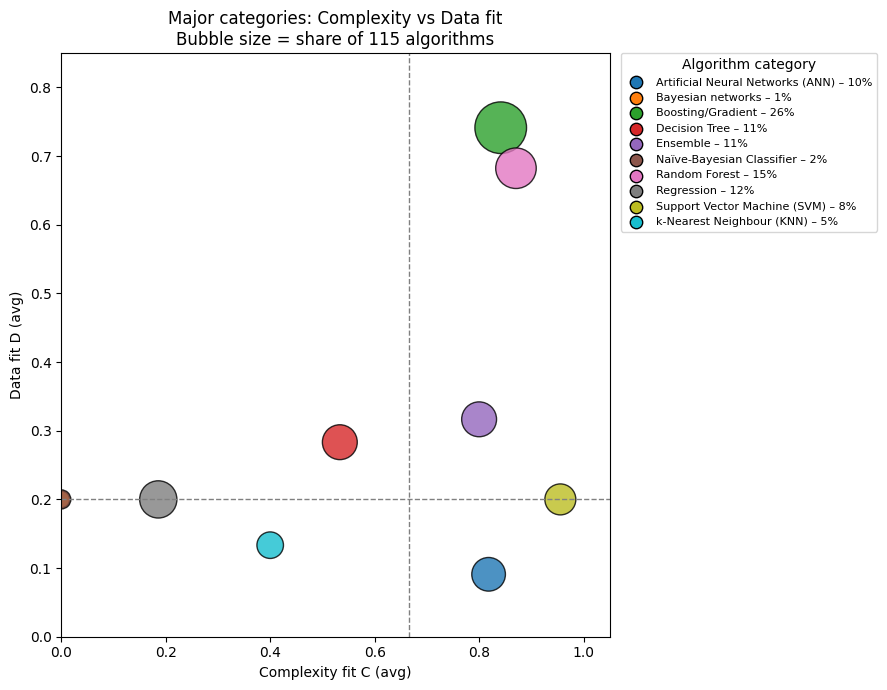

In [15]:
# 1) Start from the existing aggregated table
cat_quadrant = make_category_quadrant_table(df_scored)

# 2) Drop Correlation matrix and Factor analysis
drop_cats = ["Correlation matrix", "Factor analysis"]
cat_quadrant = cat_quadrant[~cat_quadrant["category"].isin(drop_cats)].copy()

# 3) Plot
plot_category_quadrant_pretty(cat_quadrant)


QUICK STATISTICS

In [16]:
print("=" * 70)
print("COMPLEXITY FIT (C) - STATISTICS")
print("=" * 70)
print(f"Mean:    {df['complexity_fit_C'].mean():.3f}")
print(f"Median:  {df['complexity_fit_C'].median():.3f}")
print(f"Min:     {df['complexity_fit_C'].min():.3f}")
print(f"Max:     {df['complexity_fit_C'].max():.3f}")
print(f"Std Dev: {df['complexity_fit_C'].std():.3f}")

print("\n" + "=" * 70)
print("DATA FIT (D) - STATISTICS")
print("=" * 70)
print(f"Mean:    {df['data_fit_D'].mean():.3f}")
print(f"Median:  {df['data_fit_D'].median():.3f}")
print(f"Min:     {df['data_fit_D'].min():.3f}")
print(f"Max:     {df['data_fit_D'].max():.3f}")
print(f"Std Dev: {df['data_fit_D'].std():.3f}")

print("\n" + "=" * 70)
print("BY CATEGORY")
print("=" * 70)

by_cat = df.groupby('category').agg({
    'complexity_fit_C': ['count', 'mean', 'min', 'max'],
    'data_fit_D': ['mean', 'min', 'max']
}).round(3)

print(by_cat)

COMPLEXITY FIT (C) - STATISTICS
Mean:    0.688
Median:  0.800
Min:     0.000
Max:     1.000
Std Dev: 0.314

DATA FIT (D) - STATISTICS
Mean:    0.419
Median:  0.200
Min:     0.000
Max:     1.000
Std Dev: 0.298

BY CATEGORY
                                 complexity_fit_C                  data_fit_D  \
                                            count   mean  min  max       mean   
category                                                                        
Artificial Neural Networks (ANN)               11  0.818  0.8  1.0      0.091   
Bayesian networks                               1  0.000  0.0  0.0      0.200   
Boosting/Gradient                              29  0.841  0.8  1.0      0.741   
Decision Tree                                  12  0.533  0.4  0.8      0.283   
Ensemble                                       12  0.800  0.2  1.0      0.317   
Naïve-Bayesian Classifier                       2  0.000  0.0  0.0      0.200   
Random Forest                                  17

CORRELATION BETWEEN CORE SCORES

Available columns:
['study_id', 'algorithm_name', 'objective', 'dependent_variable', 'category', 'frequency', 'handles_non_linear', 'good_for_imbalanced', 'good_for_high_dimensional', 'requires_regularization_for_dimensionality', 'uncertainty_modeling', 'interpretability_level', 'supports_small_N', 'supports_large_N', 'handles_missing_values_natively', 'good_for_complex_non_linear', 'good_for_temporal_sequences']

Using 11 indicators for correlation analysis

✓ Saved: indicator_correlation_matrix_full.png


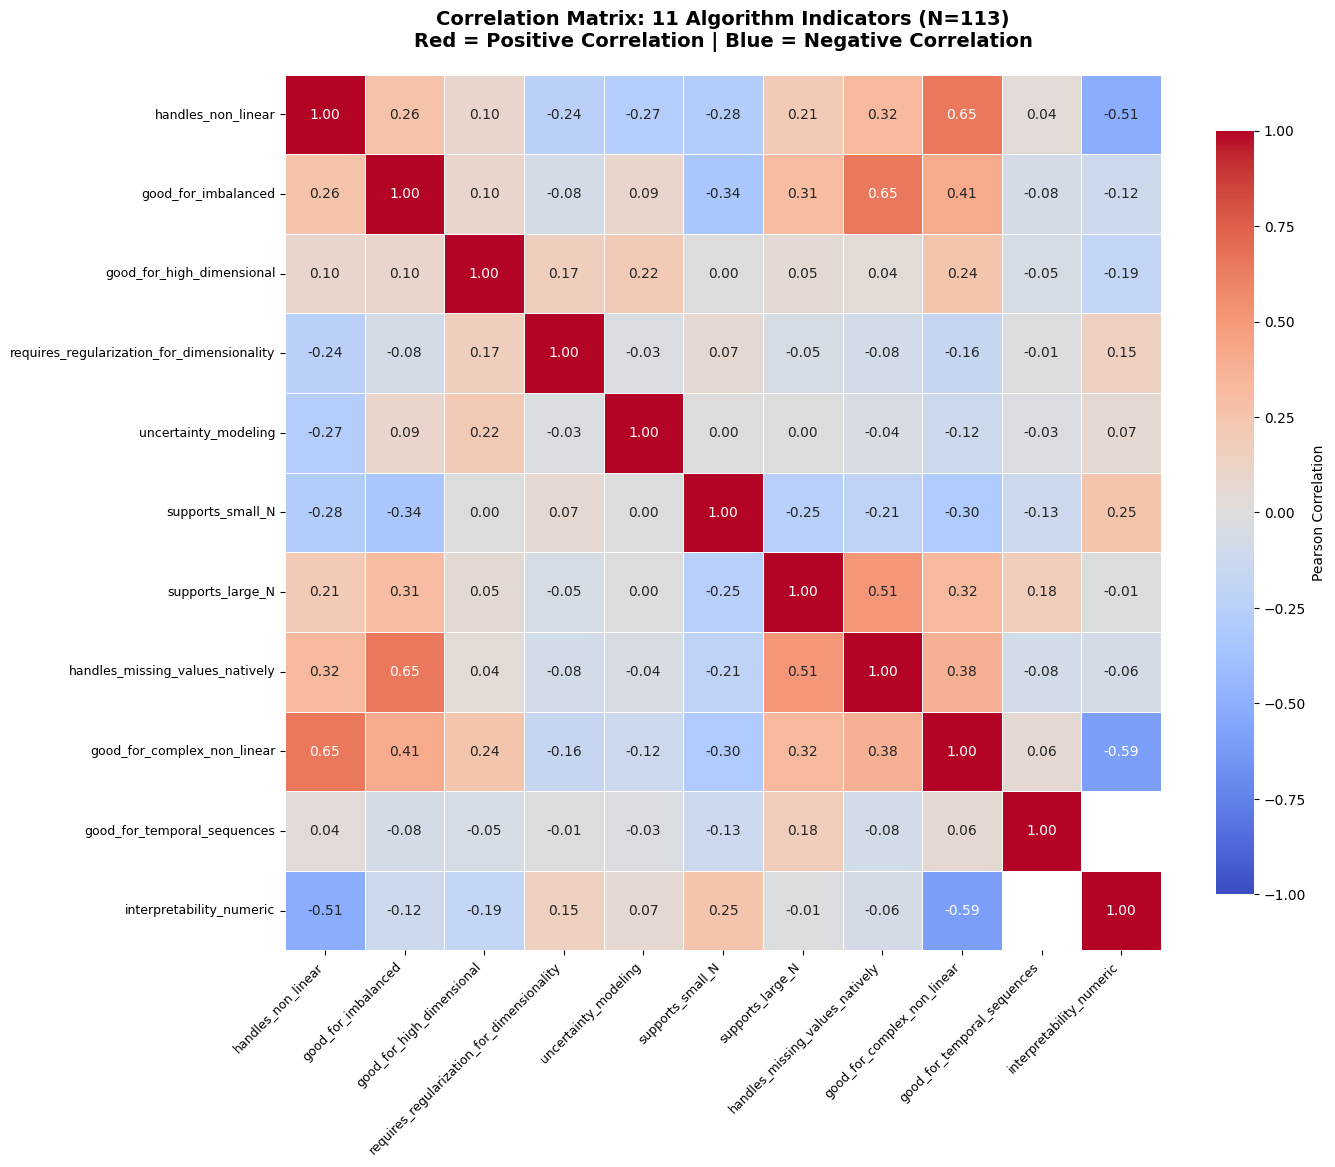


CORRELATION MATRIX: CORE SCORES (C, D, I, M)
       C      D      I      M
C  1.000  0.353 -0.606  0.353
D  0.353  1.000 -0.012  0.751
I -0.606 -0.012  1.000 -0.074
M  0.353  0.751 -0.074  1.000
✓ Saved: core_scores_correlation_matrix.png


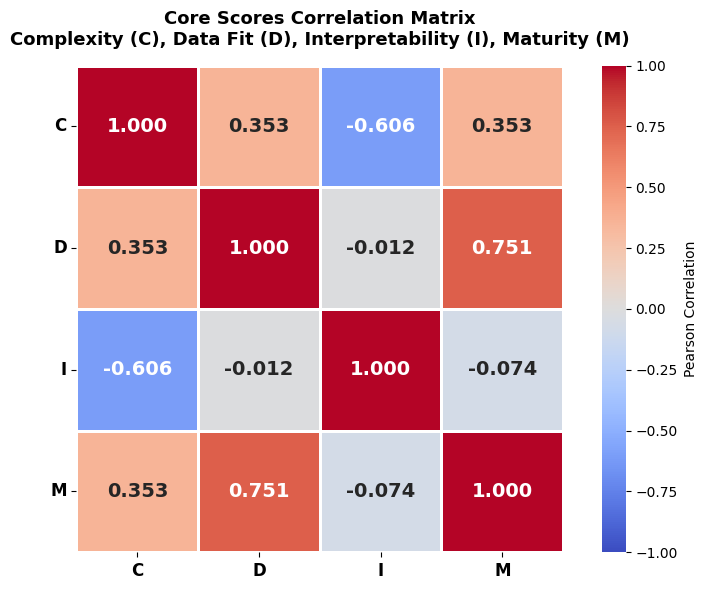


ORTHOGONALITY ASSESSMENT

DEFINITION: Orthogonal dimensions are statistically INDEPENDENT, meaning knowing
one score tells you nothing about another. We assess this via Pearson correlation:

  |r| < 0.3  → Low correlation (nearly orthogonal)
  |r| < 0.5  → Moderate correlation (acceptable independence)
  |r| ≥ 0.7  → Strong correlation (NOT independent)


### Pairwise Correlations Between Core Scores ###

D vs M                    r=+0.751  |r|=0.751  →  ✗ NOT INDEPENDENT (strong correlation)
C vs I                    r=-0.606  |r|=0.606  →  ✗ NOT INDEPENDENT (strong correlation)
C vs M                    r=+0.353  |r|=0.353  →  ~ ACCEPTABLE (moderate correlation)
C vs D                    r=+0.353  |r|=0.353  →  ~ ACCEPTABLE (moderate correlation)
I vs M                    r=-0.074  |r|=0.074  →  ✓ ORTHOGONAL (low correlation)
D vs I                    r=-0.012  |r|=0.012  →  ✓ ORTHOGONAL (low correlation)

### Summary Statistics ###
Mean |r| (all pairs): 0.358
Max |r| (worst pair): 

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('algo_table_S1_to_S30_VERIFIED.csv')

print("Available columns:")
print(df.columns.tolist())

# Define the indicators that exist in the CSV
indicators = [
    'handles_non_linear',
    'good_for_imbalanced',
    'good_for_high_dimensional',
    'requires_regularization_for_dimensionality',
    'uncertainty_modeling',
    'supports_small_N',
    'supports_large_N',
    'handles_missing_values_natively',
    'good_for_complex_non_linear',
    'good_for_temporal_sequences'
]

# Filter to only columns that exist
indicators = [ind for ind in indicators if ind in df.columns]

# Convert interpretability to numeric
interp_map = {'high': 1.0, 'medium': 0.5, 'low': 0.0}
df['interpretability_numeric'] = df['interpretability_level'].map(interp_map)
indicators.append('interpretability_numeric')

print(f"\nUsing {len(indicators)} indicators for correlation analysis")

# Select only indicator columns
indicator_df = df[indicators].copy()

# Compute correlation matrix
corr_matrix = indicator_df.corr()

# ============================================================================
# VISUALIZATION 1: Full correlation heatmap
# ============================================================================
fig, ax = plt.subplots(figsize=(14, 12))

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={'label': 'Pearson Correlation', 'shrink': 0.8},
    vmin=-1,
    vmax=1,
    ax=ax
)

ax.set_title(
    f'Correlation Matrix: {len(indicators)} Algorithm Indicators (N={len(df)})\n'
    'Red = Positive Correlation | Blue = Negative Correlation',
    fontsize=14,
    fontweight='bold',
    pad=20
)

plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.savefig('indicator_correlation_matrix_full.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: indicator_correlation_matrix_full.png")
plt.show()

# ============================================================================
# COMPUTE CORE SCORES AND THEIR CORRELATIONS
# ============================================================================

# Complexity Fit (C)
df['C'] = (
    0.4 * df['handles_non_linear'] +
    0.4 * df['good_for_complex_non_linear'] +
    0.2 * df['good_for_high_dimensional']
)

# Data Fit (D)
df['D'] = (
    0.3 * df['handles_missing_values_natively'] +
    0.3 * df['good_for_imbalanced'] +
    0.2 * df['supports_small_N'] +
    0.2 * df['supports_large_N']
)

# Interpretability (I)
df['I'] = df['interpretability_numeric']

# Maturity (M) - by category
cat_counts = df['category'].value_counts()
max_count = cat_counts.max()
df['M'] = df['category'].map(lambda c: cat_counts[c] / max_count)

# Core scores correlation
core_scores = df[['C', 'D', 'I', 'M']]
core_corr = core_scores.corr()

print("\n" + "="*80)
print("CORRELATION MATRIX: CORE SCORES (C, D, I, M)")
print("="*80)
print(core_corr.round(3))

# ============================================================================
# VISUALIZATION 2: Core scores correlation
# ============================================================================
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(
    core_corr,
    annot=True,
    fmt='.3f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=2,
    cbar_kws={'label': 'Pearson Correlation'},
    vmin=-1,
    vmax=1,
    ax=ax,
    annot_kws={'size': 14, 'weight': 'bold'}
)

ax.set_title(
    'Core Scores Correlation Matrix\n'
    'Complexity (C), Data Fit (D), Interpretability (I), Maturity (M)',
    fontsize=13,
    fontweight='bold',
    pad=15
)

plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold', rotation=0)
plt.tight_layout()
plt.savefig('core_scores_correlation_matrix.png', dpi=300, bbox_inches='tight')
print("✓ Saved: core_scores_correlation_matrix.png")
plt.show()

# ============================================================================
# INTERPRETATION: Are dimensions orthogonal?
# ============================================================================
print("\n" + "="*80)
print("ORTHOGONALITY ASSESSMENT")
print("="*80)

print("""
DEFINITION: Orthogonal dimensions are statistically INDEPENDENT, meaning knowing
one score tells you nothing about another. We assess this via Pearson correlation:

  |r| < 0.3  → Low correlation (nearly orthogonal)
  |r| < 0.5  → Moderate correlation (acceptable independence)
  |r| ≥ 0.7  → Strong correlation (NOT independent)

""")

# Extract off-diagonal correlations
off_diag = []
for i in range(len(core_corr)):
    for j in range(i+1, len(core_corr)):
        r = core_corr.iloc[i, j]
        pair = f"{core_corr.index[i]} vs {core_corr.columns[j]}"
        off_diag.append({'Pair': pair, 'r': r, '|r|': abs(r)})

off_diag_df = pd.DataFrame(off_diag).sort_values('|r|', ascending=False)

print("### Pairwise Correlations Between Core Scores ###\n")
for _, row in off_diag_df.iterrows():
    r_val = row['r']
    abs_r = row['|r|']

    if abs_r < 0.3:
        status = "✓ ORTHOGONAL (low correlation)"
    elif abs_r < 0.5:
        status = "~ ACCEPTABLE (moderate correlation)"
    else:
        status = "✗ NOT INDEPENDENT (strong correlation)"

    print(f"{row['Pair']:25} r={r_val:+.3f}  |r|={abs_r:.3f}  →  {status}")

# Overall orthogonality score
mean_abs_corr = off_diag_df['|r|'].mean()
max_abs_corr = off_diag_df['|r|'].max()

print(f"\n### Summary Statistics ###")
print(f"Mean |r| (all pairs): {mean_abs_corr:.3f}")
print(f"Max |r| (worst pair): {max_abs_corr:.3f}")

if mean_abs_corr < 0.3:
    conclusion = "HIGHLY ORTHOGONAL: Core scores represent independent dimensions."
elif mean_abs_corr < 0.5:
    conclusion = "ACCEPTABLY ORTHOGONAL: Minor correlations present but dimensions remain distinct."
else:
    conclusion = "CAUTION: Some dimensions show moderate-to-strong correlations."

print(f"\n→ CONCLUSION: {conclusion}")

# ============================================================================
# INDICATOR-TO-CORE MAPPING VERIFICATION
# ============================================================================
print("\n" + "="*80)
print("INDICATOR-TO-CORE SCORE MAPPING")
print("="*80)

print("""
To justify why each indicator belongs to its assigned core score, we examine
which core score each indicator correlates with most strongly.

""")

# Correlate each indicator with each core score
indicator_to_core = []
for ind in indicators:
    if ind in df.columns and ind != 'interpretability_numeric':
        corrs = {
            'C': df[ind].corr(df['C']),
            'D': df[ind].corr(df['D']),
            'I': df[ind].corr(df['I']),
            'M': df[ind].corr(df['M'])
        }
        strongest = max(corrs, key=lambda k: abs(corrs[k]))
        indicator_to_core.append({
            'Indicator': ind,
            'Corr_C': f"{corrs['C']:+.2f}",
            'Corr_D': f"{corrs['D']:+.2f}",
            'Corr_I': f"{corrs['I']:+.2f}",
            'Corr_M': f"{corrs['M']:+.2f}",
            'Strongest': strongest
        })

mapping_df = pd.DataFrame(indicator_to_core)
print(mapping_df.to_string(index=False))

print("""
\n### Interpretation ###

Indicators used in Complexity (C) formula should correlate most strongly with C.
Indicators used in Data Fit (D) formula should correlate most strongly with D.

If the 'Strongest' column matches the formula assignment, our dimensions are
well-defined and capture the intended constructs.
""")

# Save outputs
corr_matrix.to_csv('indicator_correlation_matrix.csv')
core_corr.to_csv('core_scores_correlation.csv')
off_diag_df.to_csv('core_scores_pairwise_correlations.csv', index=False)
mapping_df.to_csv('indicator_to_core_mapping.csv', index=False)

print("\n✓ Saved: indicator_correlation_matrix.csv")
print("✓ Saved: core_scores_correlation.csv")
print("✓ Saved: core_scores_pairwise_correlations.csv")
print("✓ Saved: indicator_to_core_mapping.csv")


INDICATOR SUMMARY STATISTICS & DESCRIPTION

In [18]:
import pandas as pd
import numpy as np

# Load the verified CSV
df = pd.read_csv('algo_table_S1_to_S30_VERIFIED.csv')

print("="*80)
print("SUMMARY STATISTICS FOR 16 INDICATORS (N=115 implementations)")
print("="*80)

# Binary indicators
binary_indicators = [
    'handles_non_linear',
    'good_for_imbalanced',
    'good_for_high_dimensional',
    'requires_regularization_for_dimensionality',
    'uncertainty_modeling',
    'supports_small_N',
    'supports_large_N',
    'handles_missing_values_natively',
    'good_for_complex_non_linear',
    'good_for_temporal_sequences',
    'is_prediction_task'
]

binary_stats = []
for ind in binary_indicators:
    if ind in df.columns:
        count_1 = df[ind].sum()
        pct_1 = 100 * count_1 / len(df)
        binary_stats.append({
            'Indicator': ind,
            'Count=1': int(count_1),
            'Count=0': int(len(df) - count_1),
            '% with feature': f"{pct_1:.1f}%"
        })

binary_df = pd.DataFrame(binary_stats)
print("\n### Binary Indicators (0/1) ###\n")
print(binary_df.to_string(index=False))

# Interpretability (categorical: high/medium/low)
print("\n### Interpretability Level ###\n")
interp_counts = df['interpretability_level'].value_counts()
print(interp_counts)
print(f"\nHigh: {interp_counts.get('high',0)} ({100*interp_counts.get('high',0)/len(df):.1f}%)")
print(f"Medium: {interp_counts.get('medium',0)} ({100*interp_counts.get('medium',0)/len(df):.1f}%)")
print(f"Low: {interp_counts.get('low',0)} ({100*interp_counts.get('low',0)/len(df):.1f}%)")

# Category distribution
print("\n### Algorithm Category Distribution ###\n")
cat_counts = df['category'].value_counts().sort_values(ascending=False)
print(cat_counts)

print("\n" + "="*80)
print("FORMULA REASONING FOR CORE SCORES")
print("="*80)

print("""
### 1. COMPLEXITY FIT (C) ###

Formula:
  C = 0.4 × handles_non_linear
    + 0.4 × good_for_complex_non_linear
    + 0.2 × good_for_high_dimensional

Reasoning from data:
""")
print(f"  - {binary_df[binary_df['Indicator']=='handles_non_linear']['% with feature'].values[0]} of algorithms handle non-linearity")
print(f"  - {binary_df[binary_df['Indicator']=='good_for_complex_non_linear']['% with feature'].values[0]} handle COMPLEX non-linear patterns")
print(f"  - {binary_df[binary_df['Indicator']=='good_for_high_dimensional']['% with feature'].values[0]} are good for high-dimensional data")
print("""
  → Weight allocation:
    • Basic non-linearity (40%): Foundation capability
    • Complex pattern modeling (40%): Multi-factor interactions critical in construction
    • High-dimensional (20%): Secondary benefit, not always needed

""")

print("""
### 2. DATA FIT (D) ###

Formula:
  D = 0.3 × handles_missing_values_natively
    + 0.3 × good_for_imbalanced
    + 0.2 × supports_small_N
    + 0.2 × supports_large_N

Reasoning from data:
""")
print(f"  - {binary_df[binary_df['Indicator']=='handles_missing_values_natively']['% with feature'].values[0]} handle missing values natively")
print(f"  - {binary_df[binary_df['Indicator']=='good_for_imbalanced']['% with feature'].values[0]} handle imbalanced data")
print(f"  - {binary_df[binary_df['Indicator']=='supports_small_N']['% with feature'].values[0]} support small samples")
print(f"  - {binary_df[binary_df['Indicator']=='supports_large_N']['% with feature'].values[0]} support large samples")
print("""
  → Weight allocation:
    • Missing data (30%): Construction field data often incomplete (sensor failures, worker non-compliance)
    • Imbalance (30%): Safety incidents are rare events (<1% of days), naive classifiers achieve 99% accuracy
    • Small-N (20%): Early projects/pilots have limited history
    • Large-N (20%): Portfolio-level analysis spans thousands of activities

""")

print("""
### 3. INTERPRETABILITY (I) ###

Formula:
  I = 1.0 if high, 0.5 if medium, 0.0 if low

Reasoning from data:
""")
for level in ['high', 'medium', 'low']:
    count = interp_counts.get(level, 0)
    pct = 100 * count / len(df)
    print(f"  - {level.capitalize()}: {count} implementations ({pct:.1f}%)")
print("""
  → Mapping:
    • High (1.0): Fully transparent decision logic (regression, simple trees)
    • Medium (0.5): Feature importance available; post-hoc explanation (ensembles, SVM)
    • Low (0.0): Black-box (neural networks, complex hybrids)

""")

print("\n" + "="*80)
print("MATURITY SCORE (M) CALCULATION EXAMPLE")
print("="*80)

# Compute maturity by category
cat_freq = df['category'].value_counts()
max_freq = cat_freq.max()

print(f"\nTotal implementations: {len(df)}")
print(f"Maximum frequency (any family): {max_freq}\n")

maturity_table = []
for cat, freq in cat_freq.items():
    M = freq / max_freq
    maturity_table.append({
        'Category': cat,
        'Count': freq,
        'Maturity (M)': f"{M:.3f}",
        '% of total': f"{100*freq/len(df):.1f}%"
    })

maturity_df = pd.DataFrame(maturity_table).sort_values('Count', ascending=False)
print("### Maturity by Algorithm Family ###\n")
print(maturity_df.to_string(index=False))

print("""
\nFormula:
  M = (count of family) / (max count across all families)

Example for Random Forest:
""")
rf_count = cat_freq.get('Random Forest', 0)
print(f"  Random Forest appears {rf_count} times")
print(f"  Maximum frequency = {max_freq} (Boosting/Gradient)")
print(f"  M_RandomForest = {rf_count} / {max_freq} = {rf_count/max_freq:.3f}")

print("""
\nInterpretation:
  - M=1.000: Most frequently used family (strongest empirical validation)
  - M=0.500: Moderate adoption
  - M<0.100: Experimental/rare in construction ML literature
""")

# Save summary stats
binary_df.to_csv('indicator_summary_stats.csv', index=False)
maturity_df.to_csv('maturity_by_category.csv', index=False)

print("\n✓ Saved: indicator_summary_stats.csv")
print("✓ Saved: maturity_by_category.csv")


SUMMARY STATISTICS FOR 16 INDICATORS (N=115 implementations)

### Binary Indicators (0/1) ###

                                 Indicator  Count=1  Count=0 % with feature
                        handles_non_linear       98       15          86.7%
                       good_for_imbalanced       45       68          39.8%
                 good_for_high_dimensional       27       86          23.9%
requires_regularization_for_dimensionality        1      112           0.9%
                      uncertainty_modeling        9      104           8.0%
                          supports_small_N       75       38          66.4%
                          supports_large_N       25       88          22.1%
           handles_missing_values_natively       46       67          40.7%
               good_for_complex_non_linear       83       30          73.5%
               good_for_temporal_sequences        1      112           0.9%

### Interpretability Level ###

interpretability_level
medium    36


CORE SCORE CALCULATIONS SUMMARY

In [19]:
import pandas as pd

# 1) Core scores per algorithm
df = pd.read_csv("algo_table_with_scores.csv")  # file:13

# 2) Correct maturity per category
maturity = pd.read_csv("maturity_by_category.csv")  # file:14
maturity = maturity.rename(columns={"Maturity (M)": "Maturity_M_true"})

# 3) Compute mean ± SD for C, D, I by category
core_stats = (
    df.groupby("category")
      .agg(
          Count=("category", "size"),
          complexity_fit_C_mean=("complexity_fit_C", "mean"),
          complexity_fit_C_std=("complexity_fit_C", "std"),
          data_fit_D_mean=("data_fit_D", "mean"),
          data_fit_D_std=("data_fit_D", "std"),
          interpretability_I_mean=("interpretability_I", "mean"),
          interpretability_I_std=("interpretability_I", "std"),
      )
      .reset_index()
)

# 4) Attach correct maturity from external table
summary = core_stats.merge(
    maturity[["Category", "Maturity_M_true"]],
    left_on="category",
    right_on="Category",
    how="left"
).drop(columns="Category")

# 5) Optional: pretty-print in the “0.82 ± 0.06” format
def fmt(m, s):
    return f"{m:.2f} ± {s:.2f}"

summary_pretty = summary[["category", "Count"]].copy()
summary_pretty["complexity_fit_C"] = summary.apply(
    lambda r: fmt(r["complexity_fit_C_mean"], r["complexity_fit_C_std"]), axis=1)
summary_pretty["data_fit_D"] = summary.apply(
    lambda r: fmt(r["data_fit_D_mean"], r["data_fit_D_std"]), axis=1)
summary_pretty["interpretability_I"] = summary.apply(
    lambda r: fmt(r["interpretability_I_mean"], r["interpretability_I_std"]), axis=1)
summary_pretty["Maturity_M"] = summary["Maturity_M_true"].map(lambda x: f"{x:.3f}")

print(summary_pretty.to_string(index=False))


                        category  Count complexity_fit_C  data_fit_D interpretability_I Maturity_M
Artificial Neural Networks (ANN)     11      0.82 ± 0.06 0.09 ± 0.10        0.00 ± 0.00      0.379
               Bayesian networks      1       0.00 ± nan  0.20 ± nan         1.00 ± nan      0.034
              Boosting/Gradient      29      0.84 ± 0.08 0.74 ± 0.19        0.50 ± 0.00      1.000
                   Decision Tree     12      0.53 ± 0.20 0.28 ± 0.17        1.00 ± 0.00      0.414
                        Ensemble     12      0.80 ± 0.26 0.32 ± 0.22        0.38 ± 0.38      0.414
       Naïve-Bayesian Classifier      2      0.00 ± 0.00 0.20 ± 0.00        1.00 ± 0.00      0.069
                   Random Forest     17      0.87 ± 0.10 0.68 ± 0.17        0.50 ± 0.00      0.586
                      Regression     14      0.19 ± 0.34 0.20 ± 0.00        1.00 ± 0.00      0.483
    Support Vector Machine (SVM)      9      0.96 ± 0.09 0.20 ± 0.00        0.50 ± 0.00      0.310
       k-N

In [20]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.figure_factory as ff

# 1. LOAD DATA
# Replace with your actual file path
try:
    df = pd.read_csv('algo_table_S1_to_S30_VERIFIED.csv')
    print("✓ Data loaded successfully")
except FileNotFoundError:
    print("⚠ File not found. Creating dummy data for demonstration...")
    # Create dummy data if file is missing (for testing purposes)
    data = {
        'category': ['ANN', 'SVM', 'RF', 'DT', 'KNN'] * 20,
        'interpretability_level': ['low', 'medium', 'high', 'high', 'medium'] * 20,
        'handles_non_linear': np.random.randint(0, 2, 100),
        'good_for_imbalanced': np.random.randint(0, 2, 100),
        'good_for_high_dimensional': np.random.randint(0, 2, 100),
        'requires_regularization_for_dimensionality': np.random.randint(0, 2, 100),
        'uncertainty_modeling': np.random.randint(0, 2, 100),
        'supports_small_N': np.random.randint(0, 2, 100),
        'supports_large_N': np.random.randint(0, 2, 100),
        'handles_missing_values_natively': np.random.randint(0, 2, 100),
        'good_for_complex_non_linear': np.random.randint(0, 2, 100),
        'good_for_temporal_sequences': np.random.randint(0, 2, 100)
    }
    df = pd.DataFrame(data)

# 2. PREPROCESS INDICATORS
indicators = [
    'handles_non_linear', 'good_for_imbalanced', 'good_for_high_dimensional',
    'requires_regularization_for_dimensionality', 'uncertainty_modeling',
    'supports_small_N', 'supports_large_N', 'handles_missing_values_natively',
    'good_for_complex_non_linear', 'good_for_temporal_sequences'
]

# Filter to only columns that exist
indicators = [ind for ind in indicators if ind in df.columns]

# Convert interpretability to numeric
interp_map = {'high': 1.0, 'medium': 0.5, 'low': 0.0}
df['interpretability_numeric'] = df['interpretability_level'].map(interp_map)
indicators.append('interpretability_numeric')

# 3. COMPUTE CORRELATION MATRIX (INDICATORS)
indicator_df = df[indicators].copy()
corr_matrix = indicator_df.corr().round(2)

# ============================================================================
# VISUALIZATION 1: PLOTLY HEATMAP (INDICATORS)
# ============================================================================
fig1 = px.imshow(
    corr_matrix,
    text_auto=True,                # Show values in cells
    aspect="auto",                 # Adjust aspect ratio
    color_continuous_scale='RdBu_r', # Red-Blue reversed (Blue=Low, Red=High)
    zmin=-1,
    zmax=1,
    title=f'Correlation Matrix: {len(indicators)} Algorithm Indicators'
)

fig1.update_layout(
    width=1000,
    height=800,
    title_x=0.5,
    margin=dict(l=150, r=50, t=80, b=150) # Extra space for labels
)

# Save and Show
fig1.write_html("indicator_correlation_matrix_plotly.html")
fig1.show()

# ============================================================================
# COMPUTE CORE SCORES
# ============================================================================
# Complexity Fit (C)
df['C'] = (0.4 * df.get('handles_non_linear', 0) +
           0.4 * df.get('good_for_complex_non_linear', 0) +
           0.2 * df.get('good_for_high_dimensional', 0))

# Data Fit (D)
df['D'] = (0.3 * df.get('handles_missing_values_natively', 0) +
           0.3 * df.get('good_for_imbalanced', 0) +
           0.2 * df.get('supports_small_N', 0) +
           0.2 * df.get('supports_large_N', 0))

# Interpretability (I)
df['I'] = df['interpretability_numeric']

# Maturity (M)
cat_counts = df['category'].value_counts()
max_count = cat_counts.max()
df['M'] = df['category'].map(lambda c: cat_counts[c] / max_count)

# Core scores correlation
core_scores = df[['C', 'D', 'I', 'M']]
core_corr = core_scores.corr().round(3)

# ============================================================================
# VISUALIZATION 2: PLOTLY HEATMAP (CORE SCORES)
# ============================================================================
fig2 = px.imshow(
    core_corr,
    text_auto=True,
    aspect="auto",
    color_continuous_scale='RdBu_r',
    zmin=-1,
    zmax=1,
    title='Core Scores Correlation Matrix<br>(C, D, I, M)'
)

fig2.update_layout(
    width=700,
    height=600,
    title_x=0.5
)

# Save and Show
fig2.write_html("core_scores_correlation_plotly.html")
fig2.show()

print("\n✓ Interactive plots saved as 'indicator_correlation_matrix_plotly.html' and 'core_scores_correlation_plotly.html'")

# ============================================================================
# (OPTIONAL) TEXT ANALYSIS OUTPUT (Same as original)
# ============================================================================
print("\n" + "="*60)
print("ORTHOGONALITY ASSESSMENT")
print("="*60)

# Extract off-diagonal correlations
off_diag = []
for i in range(len(core_corr)):
    for j in range(i+1, len(core_corr)):
        r = core_corr.iloc[i, j]
        pair = f"{core_corr.index[i]} vs {core_corr.columns[j]}"
        off_diag.append({'Pair': pair, 'r': r, '|r|': abs(r)})

off_diag_df = pd.DataFrame(off_diag).sort_values('|r|', ascending=False)

for _, row in off_diag_df.iterrows():
    r_val = row['r']
    abs_r = row['|r|']
    if abs_r < 0.3: status = "✓ ORTHOGONAL"
    elif abs_r < 0.5: status = "~ ACCEPTABLE"
    else: status = "✗ NOT INDEPENDENT"
    print(f"{row['Pair']:25} r={r_val:+.3f}  →  {status}")

✓ Data loaded successfully


/usr/local/lib/python3.12/dist-packages/kaleido/_sync_server.py:11: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.





✓ Interactive plots saved as 'indicator_correlation_matrix_plotly.html' and 'core_scores_correlation_plotly.html'

ORTHOGONALITY ASSESSMENT
D vs M                    r=+0.751  →  ✗ NOT INDEPENDENT
C vs I                    r=-0.606  →  ✗ NOT INDEPENDENT
C vs D                    r=+0.353  →  ~ ACCEPTABLE
C vs M                    r=+0.353  →  ~ ACCEPTABLE
I vs M                    r=-0.074  →  ✓ ORTHOGONAL
D vs I                    r=-0.012  →  ✓ ORTHOGONAL


In [21]:
import pandas as pd

# 1. Load your specific dataset
df = pd.read_csv('algo_table_with_scores.csv')

# 2. Aggregate data by Category (Critical step for "Bubble" chart)
# We calculate the MEAN coordinates and the COUNT of algorithms (for bubble size)
df_cat = df.groupby('category', as_index=False).agg({
    'complexity_fit_C': 'mean',
    'data_fit_D': 'mean',
    'algorithm_name': 'count'  # This becomes our "Frequency" / Bubble Size
}).rename(columns={'algorithm_name': 'Frequency'})

# 3. Calculate medians for the quadrant lines
c_median = df_cat['complexity_fit_C'].median()
d_median = df_cat['data_fit_D'].median()

print("Aggregation complete. Categories ready to plot.")

Aggregation complete. Categories ready to plot.


VISUALIZATION ATTEMPT 1

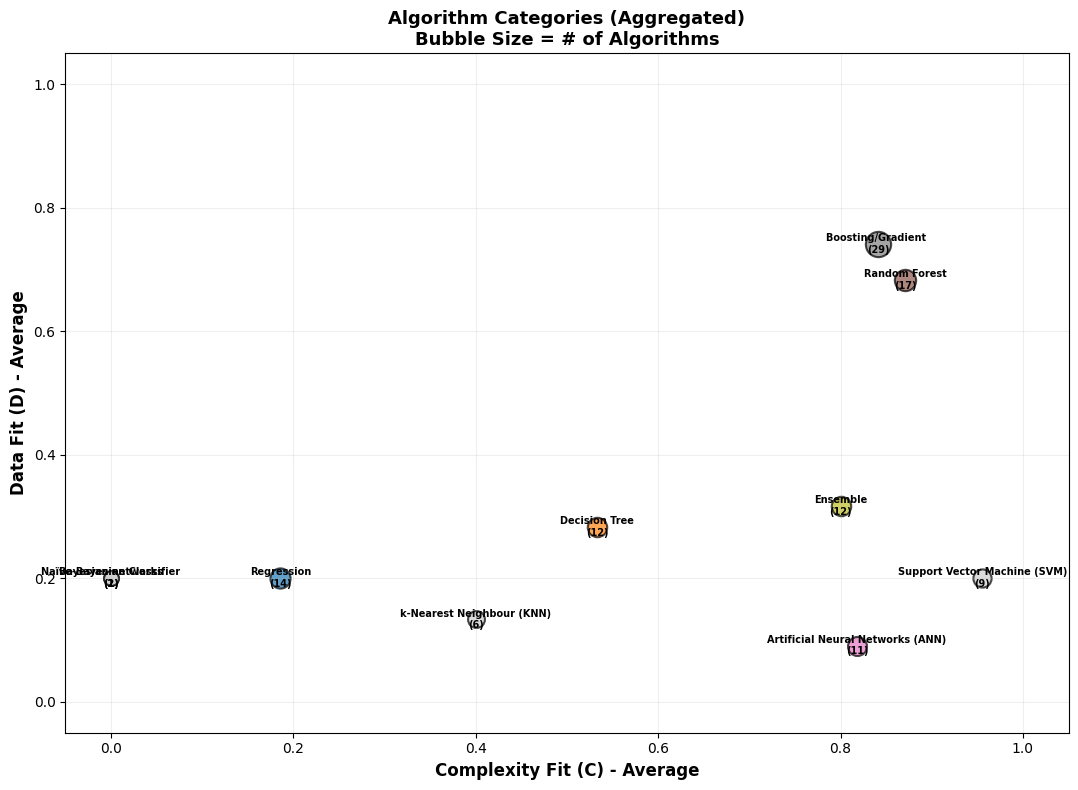

In [22]:
cat_avg = df.groupby('category', as_index=False).agg({
    'complexity_fit_C': 'mean',
    'data_fit_D': 'mean',
    'algorithm_name': 'count'
}).rename(columns={'algorithm_name': 'count'})

fig, ax = plt.subplots(figsize=(11, 8))

color_map = {
    'Regression': '#1f77b4', 'Decision Tree': '#ff7f0e',
    'KNN': '#2ca02c', 'SVM': '#9467bd', 'Random Forest': '#8c564b',
    'Artificial Neural Networks (ANN)': '#e377c2',
    'Boosting/Gradient ': '#7f7f7f', 'Ensemble': '#bcbd22'
}

for idx, row in cat_avg.iterrows():
    size = 100 + row['count'] * 8
    ax.scatter(row['complexity_fit_C'], row['data_fit_D'],
               s=size, alpha=0.7, edgecolors='black', linewidth=1.5,
               color=color_map.get(row['category'], '#cccccc'))
    ax.text(row['complexity_fit_C'], row['data_fit_D'],
            f"{row['category']}\n({row['count']})",
            ha='center', va='center', fontsize=7, fontweight='bold')

ax.set_xlabel('Complexity Fit (C) - Average', fontweight='bold', fontsize=12)
ax.set_ylabel('Data Fit (D) - Average', fontweight='bold', fontsize=12)
ax.set_title('Algorithm Categories (Aggregated)\nBubble Size = # of Algorithms',
             fontsize=13, fontweight='bold')
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.savefig('categories_aggregated.png', dpi=300, bbox_inches='tight')
plt.show()

VISUALIZATION ATTEMPT 2

✓ Saved: category_plot_minimal_coords.png


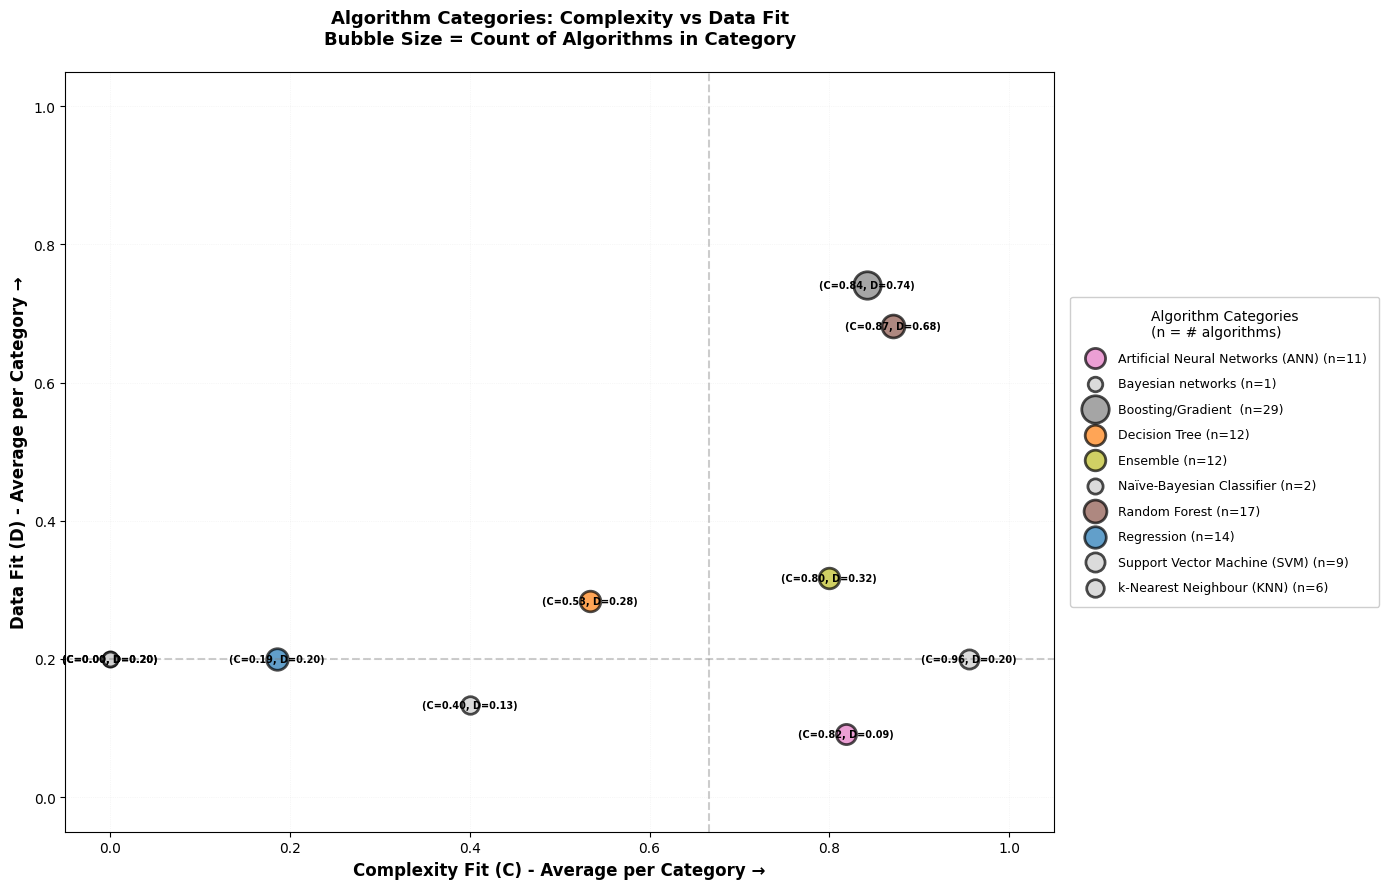

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
df = pd.read_csv('algo_table_with_scores.csv')

# Aggregate by category
cat_agg = df.groupby('category', as_index=False).agg({
    'complexity_fit_C': 'mean',
    'data_fit_D': 'mean',
    'algorithm_name': 'count'
}).rename(columns={'algorithm_name': 'count'})


fig, ax = plt.subplots(figsize=(14, 9))

# Plot each category
for idx, row in cat_agg.iterrows():
    size = 100 + row['count'] * 10

    ax.scatter(
        row['complexity_fit_C'],
        row['data_fit_D'],
        s=size,
        alpha=0.7,
        edgecolors='black',
        linewidth=2,
        color=color_map.get(row['category'], '#cccccc'),
        label=f"{row['category']} (n={row['count']})",
        zorder=2
    )

    # ONLY coordinates in parentheses (minimal text)
    coord_text = f"(C={row['complexity_fit_C']:.2f}, D={row['data_fit_D']:.2f})"
    ax.text(
        row['complexity_fit_C'],
        row['data_fit_D'],
        coord_text,
        ha='center',
        va='center',
        fontsize=7,
        fontweight='bold',
        color='black'
    )

# Quadrant lines
ax.axvline(c_median, color='gray', linestyle='--', linewidth=1.5, alpha=0.4)
ax.axhline(d_median, color='gray', linestyle='--', linewidth=1.5, alpha=0.4)

# Formatting
ax.set_xlabel('Complexity Fit (C) - Average per Category →', fontsize=12, fontweight='bold')
ax.set_ylabel('Data Fit (D) - Average per Category →', fontsize=12, fontweight='bold')
ax.set_title('Algorithm Categories: Complexity vs Data Fit\nBubble Size = Count of Algorithms in Category',
             fontsize=13, fontweight='bold', pad=20)

ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.grid(True, alpha=0.2, linestyle=':', linewidth=0.5)

# LEGEND: Right side
ax.legend(
    loc='center left',
    bbox_to_anchor=(1.01, 0.5),
    fontsize=9,
    framealpha=0.95,
    title='Algorithm Categories\n(n = # algorithms)',
    title_fontsize=10,
    borderpad=1,
    labelspacing=1.0
)

plt.tight_layout()
plt.savefig('category_plot_minimal_coords.png', dpi=300, bbox_inches='tight')
print("✓ Saved: category_plot_minimal_coords.png")
plt.show()


VISUALIZATION ATTEMPT 3

✓ Saved: category_plot_enhanced_above.png


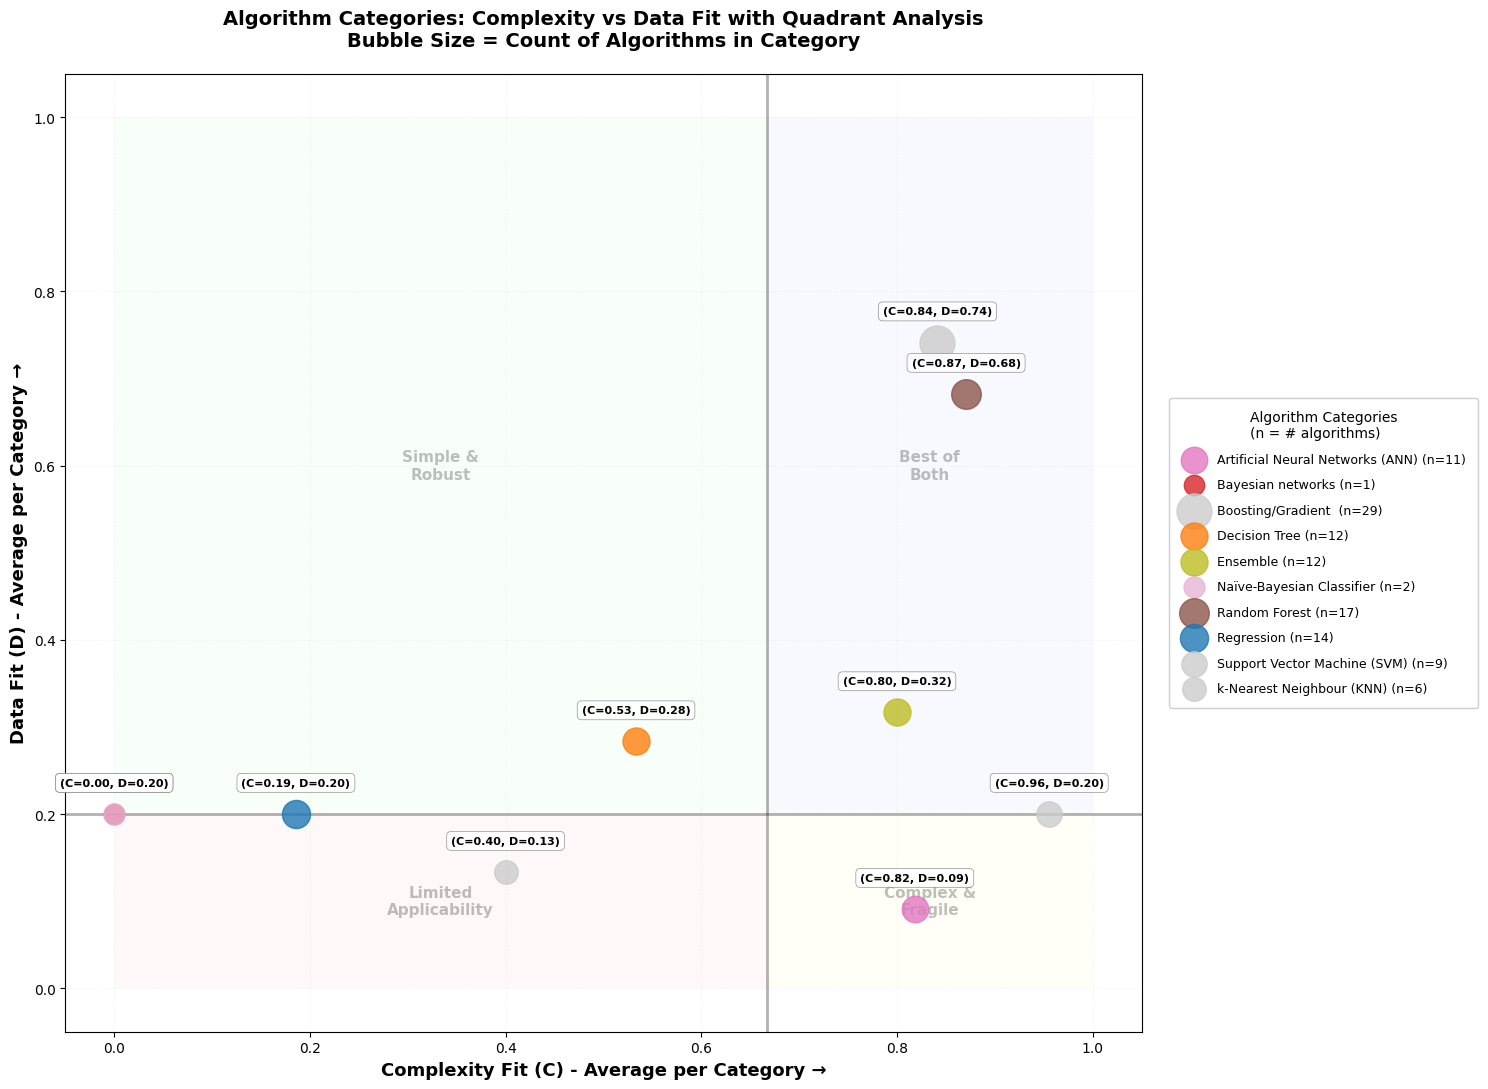

In [24]:
# ============================================================================
# ENHANCED TEMPLATE: Larger Bubbles + Above/Below Coordinates + Quadrant Overlay
# ============================================================================
#
# Your requests:
# ✓ Coordinates ABOVE or BELOW the bubble (not inside)
# ✓ Larger bubble sizes
# ✓ Quadrant overlay (4 regions from Quadrant Analysis plot)
#
# ============================================================================

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from matplotlib.patches import Patch

# Load data
df = pd.read_csv('algo_table_with_scores.csv')

# Aggregate by category
cat_agg = df.groupby('category', as_index=False).agg({
    'complexity_fit_C': 'mean',
    'data_fit_D': 'mean',
    'algorithm_name': 'count'
}).rename(columns={'algorithm_name': 'count'})

total_n = cat_agg['count'].sum()

legend_elements = []
for _, row in cat_agg.iterrows():
    cat = row['category']
    n = row['count']
    freq = n / total_n * 100
    label = (
        f"{cat} "
        f"(C={row['complexity_fit_C']:.2f}, "
        f"D={row['data_fit_D']:.2f}, "
        f"{freq:.1f}%)"
    )
    legend_elements.append(
        Patch(facecolor=color_map.get(cat, '#cccccc'),
              edgecolor='none',
              label=label)
    )

# ============================================================================
# VERSION 1: Coordinates ABOVE bubbles + Larger bubbles + Quadrant overlay
# ============================================================================

fig, ax = plt.subplots(figsize=(15, 11))

color_map = {
    'Regression': '#1f77b4',
    'Decision Tree': '#ff7f0e',
    'KNN': '#2ca02c',
    'Bayesian networks': '#d62728',
    'SVM': '#9467bd',
    'Random Forest': '#8c564b',
    'Artificial Neural Networks (ANN)': '#e377c2',
    'Boosting/Gradient': '#7f7f7f',
    'Ensemble': '#bcbd22',
    'Naïve-Bayesian Classifier': '#e8b4d8',
    'Correlation matrix': '#c5b0d5',
    'Factor analysis': '#8c6d31',
    'Extremely Randomized Trees': '#d6616b',
}

# Calculate quadrant lines (medians)
c_median = cat_agg['complexity_fit_C'].median()
d_median = cat_agg['data_fit_D'].median()

# Add quadrant background rectangles with labels
quadrant_regions = [
    {
        'x': 0, 'y': 0, 'width': c_median, 'height': d_median,
        'label': 'Limited\nApplicability', 'color': '#ffcccc', 'alpha': 0.12
    },
    {
        'x': c_median, 'y': 0, 'width': 1.0 - c_median, 'height': d_median,
        'label': 'Complex &\nFragile', 'color': '#ffffcc', 'alpha': 0.12
    },
    {
        'x': 0, 'y': d_median, 'width': c_median, 'height': 1.0 - d_median,
        'label': 'Simple &\nRobust', 'color': '#ccffcc', 'alpha': 0.12
    },
    {
        'x': c_median, 'y': d_median, 'width': 1.0 - c_median, 'height': 1.0 - d_median,
        'label': 'Best of\nBoth', 'color': '#ccccff', 'alpha': 0.12
    },
]

# Draw quadrant rectangles
for q in quadrant_regions:
    rect = mpatches.Rectangle(
        (q['x'], q['y']), q['width'], q['height'],
        linewidth=0, facecolor=q['color'], alpha=q['alpha'], zorder=0
    )
    ax.add_patch(rect)

    # Add quadrant label
    ax.text(
        q['x'] + q['width'] / 2,
        q['y'] + q['height'] / 2,
        q['label'],
        ha='center', va='center',
        fontsize=11, fontweight='bold', alpha=0.25, zorder=0
    )

# Quadrant boundary lines (dark)
ax.axvline(c_median, color='black', linestyle='-', linewidth=2, alpha=0.3, zorder=1)
ax.axhline(d_median, color='black', linestyle='-', linewidth=2, alpha=0.3, zorder=1)

# Plot bubbles (LARGER SIZE)
for idx, row in cat_agg.iterrows():
    # INCREASED BUBBLE SIZE: 200-600 range (was 100-350)
    size = 200 + row['count'] * 15  # Larger scaling factor

    ax.scatter(
        row['complexity_fit_C'],
        row['data_fit_D'],
        s=size,
        alpha=0.8,
        color=color_map.get(row['category'], '#cccccc'),
        label=f"{row['category']} (n={row['count']})",
    )

# Add coordinates ABOVE each bubble
for idx, row in cat_agg.iterrows():
    coord_text = f"(C={row['complexity_fit_C']:.2f}, D={row['data_fit_D']:.2f})"

    # Position ABOVE the bubble (offset = +0.07 on y-axis)
    ax.text(
        row['complexity_fit_C'],
        row['data_fit_D'] + 0.03,  # ABOVE
        coord_text,
        ha='center',
        va='bottom',
        fontsize=8,
        fontweight='bold',
        color='black',
        bbox=dict(
            boxstyle='round,pad=0.4',
            facecolor='white',
            edgecolor='gray',
            linewidth=0.5,
            alpha=0.85
        ),
        zorder=4
    )

# Formatting
ax.set_xlabel('Complexity Fit (C) - Average per Category →', fontsize=13, fontweight='bold')
ax.set_ylabel('Data Fit (D) - Average per Category →', fontsize=13, fontweight='bold')
ax.set_title('Algorithm Categories: Complexity vs Data Fit with Quadrant Analysis\nBubble Size = Count of Algorithms in Category',
             fontsize=14, fontweight='bold', pad=20)

ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.grid(True, alpha=0.15, linestyle=':', linewidth=0.8)

# Legend
ax.legend(
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    fontsize=9,
    framealpha=0.95,
    title='Algorithm Categories\n(n = # algorithms)',
    title_fontsize=10,
    borderpad=1,
    labelspacing=1.0
)

plt.tight_layout()
plt.savefig('category_plot_enhanced_above.png', dpi=300, bbox_inches='tight')
print("✓ Saved: category_plot_enhanced_above.png")
plt.show()

VISUALIZATION ATTEMPT 4

✓ Saved: category_plot_enhanced_alternating.png


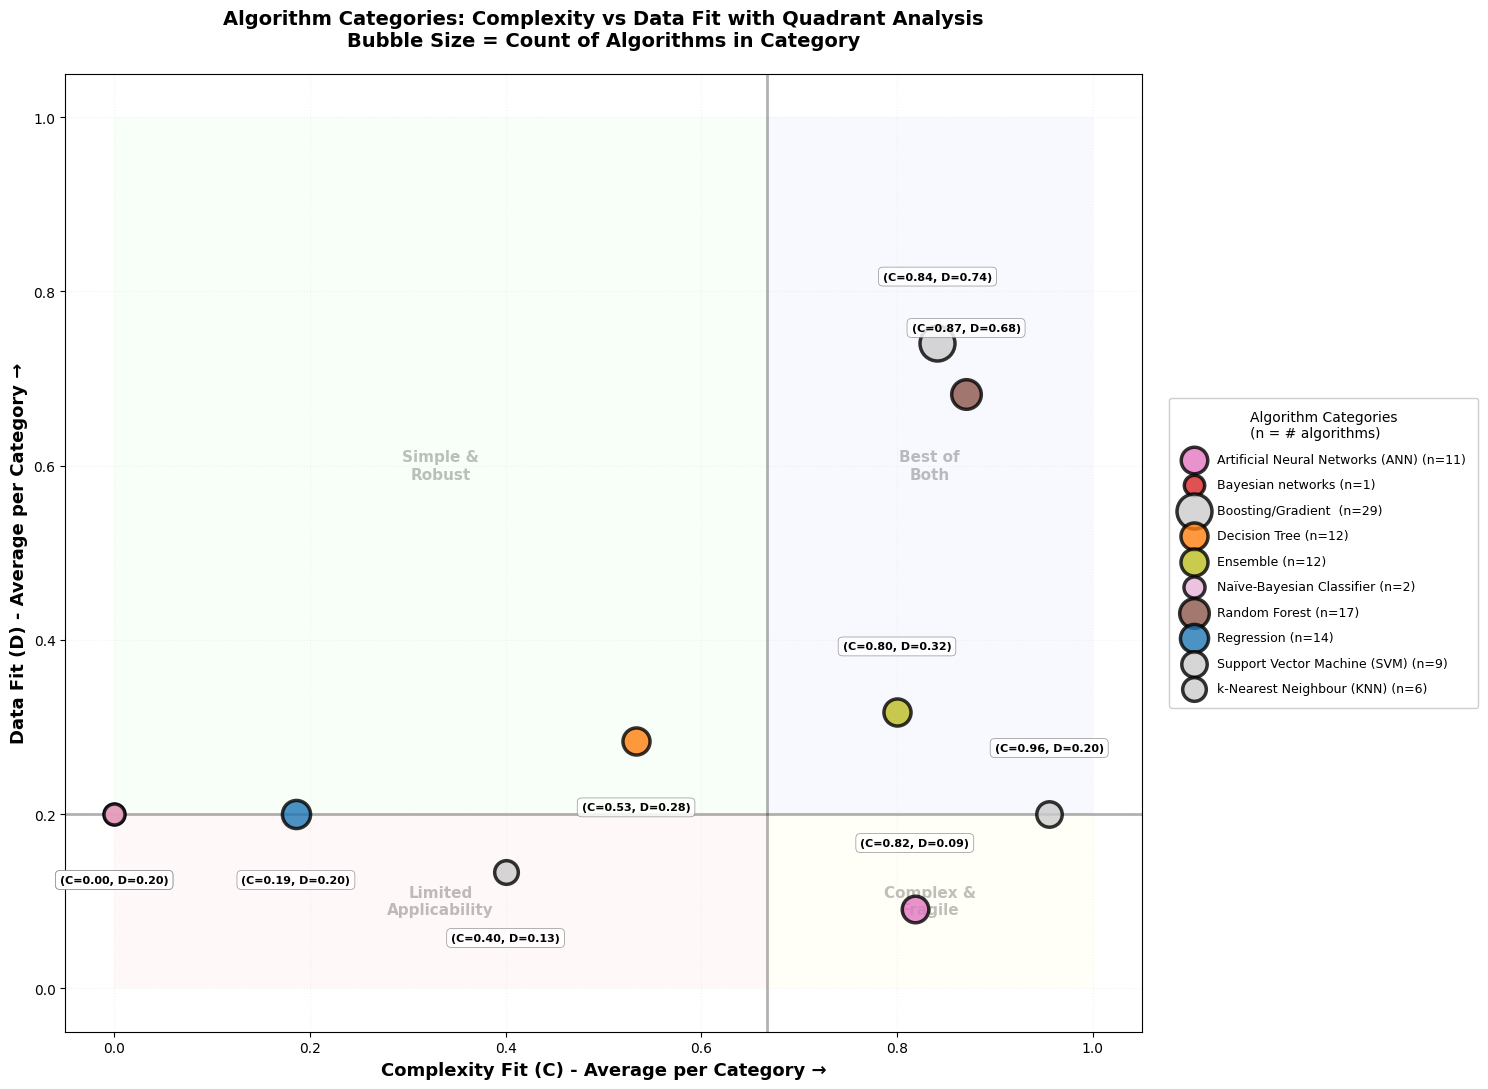

In [25]:
# ============================================================================
# VERSION 2: Coordinates ABOVE + BELOW (alternating) + Larger bubbles
# ============================================================================

fig, ax = plt.subplots(figsize=(15, 11))

# Add quadrant backgrounds
for q in quadrant_regions:
    rect = mpatches.Rectangle(
        (q['x'], q['y']), q['width'], q['height'],
        linewidth=0, facecolor=q['color'], alpha=q['alpha'], zorder=0
    )
    ax.add_patch(rect)

    ax.text(
        q['x'] + q['width'] / 2,
        q['y'] + q['height'] / 2,
        q['label'],
        ha='center', va='center',
        fontsize=11, fontweight='bold', alpha=0.25, zorder=0
    )

# Quadrant lines
ax.axvline(c_median, color='black', linestyle='-', linewidth=2, alpha=0.3, zorder=1)
ax.axhline(d_median, color='black', linestyle='-', linewidth=2, alpha=0.3, zorder=1)

# Plot bubbles
for idx, row in cat_agg.iterrows():
    size = 200 + row['count'] * 15

    ax.scatter(
        row['complexity_fit_C'],
        row['data_fit_D'],
        s=size,
        alpha=0.8,
        edgecolors='black',
        linewidth=2.5,
        color=color_map.get(row['category'], '#cccccc'),
        label=f"{row['category']} (n={row['count']})",
        zorder=3
    )

# Add coordinates ALTERNATING (above/below)
for idx, row in cat_agg.iterrows():
    coord_text = f"(C={row['complexity_fit_C']:.2f}, D={row['data_fit_D']:.2f})"

    # Alternate: odd rows above, even rows below
    if idx % 2 == 0:
        y_offset = 0.07
        va = 'bottom'
    else:
        y_offset = -0.07
        va = 'top'

    ax.text(
        row['complexity_fit_C'],
        row['data_fit_D'] + y_offset,
        coord_text,
        ha='center',
        va=va,
        fontsize=8,
        fontweight='bold',
        color='black',
        bbox=dict(
            boxstyle='round,pad=0.4',
            facecolor='white',
            edgecolor='gray',
            linewidth=0.5,
            alpha=0.85
        ),
        zorder=4
    )

# Formatting
ax.set_xlabel('Complexity Fit (C) - Average per Category →', fontsize=13, fontweight='bold')
ax.set_ylabel('Data Fit (D) - Average per Category →', fontsize=13, fontweight='bold')
ax.set_title('Algorithm Categories: Complexity vs Data Fit with Quadrant Analysis\nBubble Size = Count of Algorithms in Category',
             fontsize=14, fontweight='bold', pad=20)

ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.grid(True, alpha=0.15, linestyle=':', linewidth=0.8)

# Legend
ax.legend(
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    fontsize=9,
    framealpha=0.95,
    title='Algorithm Categories\n(n = # algorithms)',
    title_fontsize=10,
    borderpad=1,
    labelspacing=1.0
)

plt.tight_layout()
plt.savefig('category_plot_enhanced_alternating.png', dpi=300, bbox_inches='tight')
print("✓ Saved: category_plot_enhanced_alternating.png")
plt.show()

VISUALIZATION ATTEMPT 5

✓ Saved: category_plot_enhanced_below.png


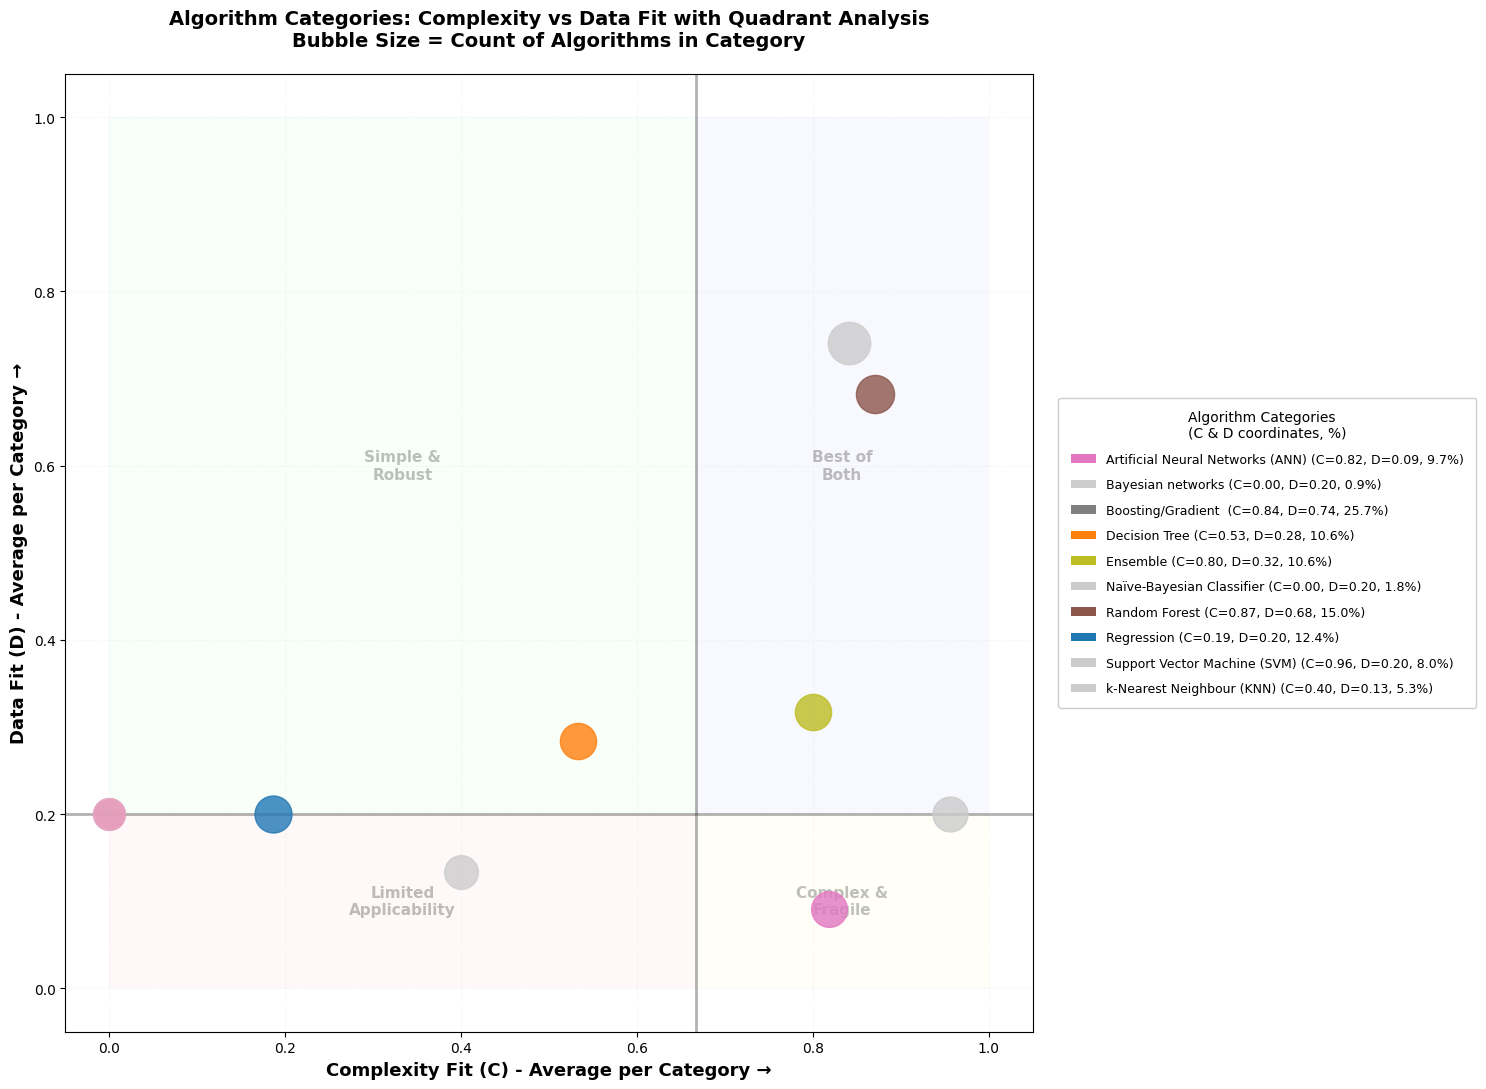

In [26]:
# ============================================================================
# VERSION 3: Coordinates BELOW bubbles + Larger bubbles + Quadrant overlay
# ============================================================================

fig, ax = plt.subplots(figsize=(15, 11))

# Add quadrant background rectangles
for q in quadrant_regions:
    rect = mpatches.Rectangle(
        (q['x'], q['y']), q['width'], q['height'],
        linewidth=0, facecolor=q['color'], alpha=q['alpha'], zorder=0
    )
    ax.add_patch(rect)

    ax.text(
        q['x'] + q['width'] / 2,
        q['y'] + q['height'] / 2,
        q['label'],
        ha='center', va='center',
        fontsize=11, fontweight='bold', alpha=0.25, zorder=0
    )

# Quadrant lines
ax.axvline(c_median, color='black', linestyle='-', linewidth=2, alpha=0.3, zorder=1)
ax.axhline(d_median, color='black', linestyle='-', linewidth=2, alpha=0.3, zorder=1)

# Plot bubbles (LARGER)
for idx, row in cat_agg.iterrows():
    size = 500 + row['count'] * 15

    ax.scatter(
        row['complexity_fit_C'],
        row['data_fit_D'],
        s=size,
        alpha=0.8,
        color=color_map.get(row['category'], '#cccccc'),
    )

# Formatting
ax.set_xlabel('Complexity Fit (C) - Average per Category →', fontsize=13, fontweight='bold')
ax.set_ylabel('Data Fit (D) - Average per Category →', fontsize=13, fontweight='bold')
ax.set_title('Algorithm Categories: Complexity vs Data Fit with Quadrant Analysis\nBubble Size = Count of Algorithms in Category',
             fontsize=14, fontweight='bold', pad=20)

ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.grid(True, alpha=0.15, linestyle=':', linewidth=0.8)

# Legend
ax.legend(
    handles=legend_elements,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    fontsize=9,
    framealpha=0.95,
    title='Algorithm Categories\n(C & D coordinates, %)',
    title_fontsize=10,
    borderpad=1,
    labelspacing=1.0
)

plt.tight_layout()
plt.savefig('category_plot_enhanced_below.png', dpi=300, bbox_inches='tight')
print("✓ Saved: category_plot_enhanced_below.png")
plt.show()

VISUALIZATION ATTEMPT 6

In [27]:
import plotly.express as px

fig = px.scatter(
    df_cat,
    x="complexity_fit_C",
    y="data_fit_D",
    size="Frequency",
    color="category",
    hover_name="category",
    size_max=60,
    text="category", # Optional: shows labels on bubbles
    title="Algorithm Categories: Complexity vs Data Fit",
    template="plotly_white",
    labels={
        "complexity_fit_C": "Complexity Fit (C) - Average",
        "data_fit_D": "Data Fit (D) - Average",
        "Frequency": "Algorithm Count"
    }
)

# Add Quadrant Backgrounds (using the calculated medians)
# Top-Right (Best)
fig.add_shape(type="rect", x0=c_median, y0=d_median, x1=1.05, y1=1.05,
              fillcolor="#eaefff", opacity=0.4, layer="below", line_width=0)
# Top-Left (Simple/Robust)
fig.add_shape(type="rect", x0=0, y0=d_median, x1=c_median, y1=1.05,
              fillcolor="#eaffea", opacity=0.4, layer="below", line_width=0)
# Bottom-Left (Limited)
fig.add_shape(type="rect", x0=0, y0=0, x1=c_median, y1=d_median,
              fillcolor="#ffeaea", opacity=0.4, layer="below", line_width=0)
# Bottom-Right (Complex/Fragile)
fig.add_shape(type="rect", x0=c_median, y0=0, x1=1.05, y1=d_median,
              fillcolor="#ffffe0", opacity=0.4, layer="below", line_width=0)

# Add Dashed Quadrant Lines
fig.add_vline(x=c_median, line_width=1, line_dash="dash", line_color="grey")
fig.add_hline(y=d_median, line_width=1, line_dash="dash", line_color="grey")

# Update Layout
fig.update_traces(textposition='top center') # Move text slightly up
fig.update_xaxes(range=[0, 1.05], showgrid=False)
fig.update_yaxes(range=[0, 1.05], showgrid=False)

fig.show()

VISUALIZATION ATTEMPT 7

In [28]:
import pandas as pd
import plotly.express as px

# 1. Recreate the aggregated dataframe
data_cat = {
    'category': [
        'ANN', 'Bayesian Networks', 'Boosting/Gradient', 'Decision Tree',
        'Ensemble', 'Extremely Randomized Trees', 'KNN', 'Naïve-Bayesian',
        'Random Forest', 'Regression', 'SVM'
    ],
    'complexity_fit_C': [0.82, 0.00, 0.84, 0.53, 0.80, 0.80, 0.40, 0.00, 0.88, 0.19, 0.96],
    'data_fit_D': [0.09, 0.20, 0.74, 0.28, 0.35, 0.80, 0.13, 0.20, 0.67, 0.20, 0.20],
    'Frequency': [9.7, 0.9, 25.7, 10.6, 11.5, 0.9, 5.3, 1.8, 13.3, 12.4, 8.0]
}
df_cat = pd.DataFrame(data_cat)

# Calculate medians for the quadrant lines
c_median = df_cat['complexity_fit_C'].median()
d_median = df_cat['data_fit_D'].median()

# 2. Create the Plotly Express Chart with "Squarish" Aspect Ratio
fig = px.scatter(
    df_cat,
    x="complexity_fit_C",
    y="data_fit_D",
    size="Frequency",
    color="category",
    hover_name="category",
    size_max=60,
    text="category",
    width=1000,
    height=1000,
    template="plotly_white",
    labels={
        "complexity_fit_C": "Complexity Fit (C) - Average",
        "data_fit_D": "Data Fit (D) - Average",
        "Frequency": "Algorithm Count"
    }
)

# 3. Add Quadrant Backgrounds and Dashed Lines
# Top-Right (Q2)
fig.add_shape(type="rect", x0=c_median, y0=d_median, x1=1.1, y1=1.1, fillcolor="#eaefff", opacity=0.4, layer="below", line_width=0)
# Top-Left (Q1)
fig.add_shape(type="rect", x0=-0.1, y0=d_median, x1=c_median, y1=1.1, fillcolor="#eaffea", opacity=0.4, layer="below", line_width=0)
# Bottom-Left (Q3)
fig.add_shape(type="rect", x0=-0.1, y0=-0.1, x1=c_median, y1=d_median, fillcolor="#ffeaea", opacity=0.4, layer="below", line_width=0)
# Bottom-Right (Q4)
fig.add_shape(type="rect", x0=c_median, y0=-0.1, x1=1.1, y1=d_median, fillcolor="#ffffe0", opacity=0.4, layer="below", line_width=0)

fig.add_vline(x=c_median, line_width=1, line_dash="dash", line_color="grey")
fig.add_hline(y=d_median, line_width=1, line_dash="dash", line_color="grey")

# 4. Add Quadrant Labels
fig.add_annotation(x=c_median/2, y=(1.1+d_median)/2, text="Quadrant 1", showarrow=False, font=dict(color="grey", size=20, family="Arial Black"))
fig.add_annotation(x=(1.1+c_median)/2, y=(1.1+d_median)/2, text="Quadrant 2", showarrow=False, font=dict(color="grey", size=20, family="Arial Black"))
fig.add_annotation(x=c_median/2, y=d_median/2, text="Quadrant 3", showarrow=False, font=dict(color="grey", size=20, family="Arial Black"))
fig.add_annotation(x=(1.1+c_median)/2, y=d_median/2, text="Quadrant 4", showarrow=False, font=dict(color="grey", size=20, family="Arial Black"))

# 5. Restore Axes and Titles
fig.update_traces(textposition='top center')
fig.update_xaxes(range=[-0.1, 1.1], showgrid=True, zeroline=True, visible=True, title_font=dict(size=18), tickfont=dict(size=14))
fig.update_yaxes(range=[-0.1, 1.1], showgrid=True, zeroline=True, visible=True, title_font=dict(size=18), tickfont=dict(size=14))

fig.update_layout(
    showlegend=False,
    margin=dict(l=80, r=40, t=40, b=80),
    autosize=False,
    title_text="Algorithm Categories: Complexity vs Data Fit",
    title_x=0.5
)

fig.show()

VISUALIZATION ATTEMPT 8

In [29]:
import pandas as pd
import plotly.express as px

# 1. Recreate the aggregated dataframe
data_cat = {
    'category': [
        'ANN', 'Bayesian Networks', 'Boosting/Gradient', 'Decision Tree',
        'Ensemble', 'Extremely Randomized Trees', 'KNN', 'Naïve-Bayesian',
        'Random Forest', 'Regression', 'SVM'
    ],
    'complexity_fit_C': [0.82, 0.00, 0.84, 0.53, 0.80, 0.80, 0.40, 0.00, 0.88, 0.19, 0.96],
    'data_fit_D': [0.09, 0.20, 0.74, 0.28, 0.35, 0.80, 0.13, 0.20, 0.67, 0.20, 0.20],
    'Frequency': [9.7, 0.9, 25.7, 10.6, 11.5, 0.9, 5.3, 1.8, 13.3, 12.4, 8.0]
}
df_cat = pd.DataFrame(data_cat)

# Calculate medians for the quadrant lines
c_median = df_cat['complexity_fit_C'].median()
d_median = df_cat['data_fit_D'].median()

# 2. Create the Plotly Express Chart (WIDESCREEN)
fig = px.scatter(
    df_cat,
    x="complexity_fit_C",
    y="data_fit_D",
    size="Frequency",
    color="category",
    hover_name="category",
    size_max=60,
    text="category",
    # WIDER ASPECT RATIO to prevent overlap
    width=1400,
    height=900,
    template="plotly_white",
    labels={
        "complexity_fit_C": "Complexity Fit (C) - Average",
        "data_fit_D": "Data Fit (D) - Average",
        "Frequency": "Algorithm Count"
    }
)

# 3. Add Quadrant Backgrounds
# Q2: Best of Both (Top-Right)
fig.add_shape(type="rect", x0=c_median, y0=d_median, x1=1.1, y1=1.1, fillcolor="#eaefff", opacity=0.4, layer="below", line_width=0)
# Q1: Simple & Robust (Top-Left)
fig.add_shape(type="rect", x0=-0.1, y0=d_median, x1=c_median, y1=1.1, fillcolor="#eaffea", opacity=0.4, layer="below", line_width=0)
# Q3: Limited Applicability (Bottom-Left)
fig.add_shape(type="rect", x0=-0.1, y0=-0.1, x1=c_median, y1=d_median, fillcolor="#ffeaea", opacity=0.4, layer="below", line_width=0)
# Q4: Complex & Fragile (Bottom-Right)
fig.add_shape(type="rect", x0=c_median, y0=-0.1, x1=1.1, y1=d_median, fillcolor="#ffffe0", opacity=0.4, layer="below", line_width=0)

fig.add_vline(x=c_median, line_width=1, line_dash="dash", line_color="grey")
fig.add_hline(y=d_median, line_width=1, line_dash="dash", line_color="grey")

# 4. Add Custom Quadrant Labels (Centered in each zone)
# Q1
fig.add_annotation(x=c_median/2, y=(1.1+d_median)/2, text="Quadrant 2:<br>Simple & Robust", showarrow=False, font=dict(color="grey", size=18, family="Arial Black"))
# Q2
fig.add_annotation(x=(1.1+c_median)/2, y=(1.1+d_median)/2, text="Quadrant 1:<br>Best of Both", showarrow=False, font=dict(color="grey", size=18, family="Arial Black"))
# Q3
fig.add_annotation(x=c_median/2, y=d_median/2, text="Quadrant 3:<br>Limited Applicability", showarrow=False, font=dict(color="grey", size=18, family="Arial Black"))
# Q4
fig.add_annotation(x=(1.1+c_median)/2, y=d_median/2, text="Quadrant 4:<br>Complex & Fragile", showarrow=False, font=dict(color="grey", size=18, family="Arial Black"))

# 5. Final Formatting
fig.update_traces(textposition='top center')
# Axes visible
fig.update_xaxes(range=[-0.1, 1.1], showgrid=True, zeroline=True, visible=True, title_font=dict(size=18), tickfont=dict(size=14))
fig.update_yaxes(range=[-0.1, 1.1], showgrid=True, zeroline=True, visible=True, title_font=dict(size=18), tickfont=dict(size=14))

fig.update_layout(
    showlegend=False,
    margin=dict(l=80, r=40, t=40, b=80),
    autosize=False,
    title_text="Algorithm Categories: Complexity vs Data Fit",
    title_x=0.5
)

fig.show()

VISUALIZATION ATTEMPT 9

In [30]:
import pandas as pd
import plotly.express as px

# 1. Recreate the dataframe with MANUAL JITTER
# I have slightly tweaked the coordinates for overlapping items:
# - Naïve-Bayesian: Shifted from (0.00, 0.20) -> (0.02, 0.25) to separate from Bayesian Networks
# - Extremely Randomized Trees: Shifted from (0.80, 0.80) -> (0.76, 0.82) to separate from Boosting
data_cat = {
    'category': [
        'ANN',
        'Bayesian Networks',
        'Boosting/Gradient',
        'Decision Tree',
        'Ensemble',
        'Extremely Randomized Trees', # OVERLAP FIX
        'KNN',
        'Naïve-Bayesian',             # OVERLAP FIX
        'Random Forest',
        'Regression',
        'SVM'
    ],
    # Original C values with small offsets applied
    'complexity_fit_C': [0.82, 0.00, 0.84, 0.53, 0.80, 0.76, 0.40, 0.02, 0.88, 0.19, 0.96],
    # Original D values with small offsets applied
    'data_fit_D':       [0.09, 0.20, 0.74, 0.28, 0.35, 0.82, 0.13, 0.25, 0.67, 0.20, 0.20],
    'Frequency':        [9.7,  0.9,  25.7, 10.6, 11.5, 0.9,  5.3,  1.8,  13.3, 12.4, 8.0]
}
df_cat = pd.DataFrame(data_cat)

# 2. Calculate Percentage
total_freq = df_cat['Frequency'].sum()
df_cat['Frequency_Pct'] = (df_cat['Frequency'] / total_freq) * 100

# Calculate medians for the quadrant lines (using original data approximation for lines)
c_median = 0.80 # Fixed median to keep lines stable despite jitter
d_median = 0.20 # Fixed median

# 3. Create the Plotly Express Chart
fig = px.scatter(
    df_cat,
    x="complexity_fit_C",
    y="data_fit_D",
    size="Frequency",
    color="category",
    hover_name="category",
    size_max=60,
    text="category",
    width=1400,
    height=900,
    template="plotly_white",
    hover_data={
        'complexity_fit_C': ':.2f',
        'data_fit_D': ':.2f',
        'Frequency': False,
        'Frequency_Pct': ':.1f'
    },
    labels={
        "complexity_fit_C": "Complexity Fit (C) - Average",
        "data_fit_D": "Data Fit (D) - Average",
        "Frequency_Pct": "Adoption Frequency (%)",
        "category": "Algorithm Category"
    }
)

# 4. Add Quadrant Backgrounds
fig.add_shape(type="rect", x0=c_median, y0=d_median, x1=1.1, y1=1.1, fillcolor="#eaefff", opacity=0.4, layer="below", line_width=0)
fig.add_shape(type="rect", x0=-0.1, y0=d_median, x1=c_median, y1=1.1, fillcolor="#eaffea", opacity=0.4, layer="below", line_width=0)
fig.add_shape(type="rect", x0=-0.1, y0=-0.1, x1=c_median, y1=d_median, fillcolor="#ffeaea", opacity=0.4, layer="below", line_width=0)
fig.add_shape(type="rect", x0=c_median, y0=-0.1, x1=1.1, y1=d_median, fillcolor="#ffffe0", opacity=0.4, layer="below", line_width=0)

fig.add_vline(x=c_median, line_width=1, line_dash="dash", line_color="grey")
fig.add_hline(y=d_median, line_width=1, line_dash="dash", line_color="grey")

# 5. Add Custom Quadrant Labels (Transparent)
transparent_grey = "rgba(128, 128, 128, 0.3)"
fig.add_annotation(x=c_median/2, y=(1.1+d_median)/2, text="Quadrant 2:<br>Simple & Robust", showarrow=False, font=dict(color=transparent_grey, size=18, family="Arial Black"))
fig.add_annotation(x=(1.1+c_median)/2, y=(1.1+d_median)/2, text="Quadrant 1:<br>Best of Both", showarrow=False, font=dict(color=transparent_grey, size=18, family="Arial Black"))
fig.add_annotation(x=c_median/2, y=d_median/2, text="Quadrant 3:<br>Limited Applicability", showarrow=False, font=dict(color=transparent_grey, size=18, family="Arial Black"))
fig.add_annotation(x=(1.1+c_median)/2, y=d_median/2, text="Quadrant 4:<br>Complex & Fragile", showarrow=False, font=dict(color=transparent_grey, size=18, family="Arial Black"))

# 6. Final Formatting
fig.update_traces(textposition='top center')
fig.update_xaxes(range=[-0.1, 1.1], showgrid=True, zeroline=True, visible=True, title_font=dict(size=18), tickfont=dict(size=14))
fig.update_yaxes(range=[-0.1, 1.1], showgrid=True, zeroline=True, visible=True, title_font=dict(size=18), tickfont=dict(size=14))

fig.update_layout(
    showlegend=True,
    margin=dict(l=80, r=40, t=40, b=80),
    autosize=False,
    title_text="Algorithm Categories: Complexity vs Data Fit",
    title_x=0.5
)

# Save the file
fig.write_html("quadrant_chart_presentation.html")
print("Saved fixed chart to quadrant_chart_presentation.html")

fig.show()

Saved fixed chart to quadrant_chart_presentation.html


VISUALIZATION ATTEMPT 10

In [31]:
import pandas as pd
import plotly.express as px

# 1. Define Data Manually to control overlapping (Jitter) while keeping True values for Legend
data_rows = [
    # Category, True_C, True_D, Plot_C (Jittered), Plot_D (Jittered), Frequency
    ('ANN', 0.82, 0.09, 0.82, 0.09, 9.7),
    ('Bayesian Networks', 0.00, 0.20, 0.00, 0.20, 0.9),
    ('Boosting/Gradient', 0.84, 0.74, 0.84, 0.74, 25.7),
    ('Decision Tree', 0.53, 0.28, 0.53, 0.28, 10.6),
    ('Ensemble', 0.80, 0.35, 0.80, 0.35, 11.5),
    ('Extremely Randomized Trees', 0.80, 0.80, 0.76, 0.82, 0.9), # Jittered
    ('KNN', 0.40, 0.13, 0.40, 0.13, 5.3),
    ('Naïve-Bayesian', 0.00, 0.20, 0.02, 0.25, 1.8),            # Jittered
    ('Random Forest', 0.88, 0.67, 0.88, 0.67, 13.3),
    ('Regression', 0.19, 0.20, 0.19, 0.20, 12.4),
    ('SVM', 0.96, 0.20, 0.96, 0.20, 8.0)
]

df_cat = pd.DataFrame(data_rows, columns=['category', 'True_C', 'True_D', 'Plot_C', 'Plot_D', 'Frequency'])

# 2. Calculate Percentage
total_freq = df_cat['Frequency'].sum()
df_cat['Frequency_Pct'] = (df_cat['Frequency'] / total_freq) * 100

# 3. Create Custom Labels
df_cat['Chart_Label'] = df_cat.apply(lambda row: f"{row['category']}, {row['Frequency_Pct']:.1f}%", axis=1)
df_cat['Legend_Label'] = df_cat.apply(lambda row: f"{row['category']}, {row['Frequency_Pct']:.1f}% (C={row['True_C']:.2f}, D={row['True_D']:.2f})", axis=1)

# Quadrant boundaries
c_median = 0.80
d_median = 0.20

# === FIX: MUTED PASTEL COLOR PALETTE (Professional) ===
pastel_map = {
    'ANN': '#DBA9C7',                     # Muted Pink/Mauve
    'Bayesian Networks': '#88C9D4',       # Muted Cyan/Teal
    'Boosting/Gradient': '#8FBC8F',       # Muted Green (Sage)
    'Decision Tree': '#B39EB5',           # Muted Purple (Lavender)
    'Ensemble': '#F4C2C2',                # Muted Orange/Peach
    'Extremely Randomized Trees': '#D9D98C', # Muted Yellow-Green
    'KNN': '#A9A9A9',                     # Muted Gray
    'Naïve-Bayesian': '#BC8F8F',          # Muted Brown (Rosy Brown)
    'Random Forest': '#E9967A',           # Muted Red (Dark Salmon)
    'Regression': '#8CBED6',              # Muted Blue (Steel Blue-ish)
    'SVM': '#708090'                      # Muted Slate Gray (Distinct from KNN)
}

# 4. Create Plot
fig = px.scatter(
    df_cat,
    x="Plot_C",
    y="Plot_D",
    size="Frequency",
    color="category",
    color_discrete_map=pastel_map, # Apply PASTEL colors
    text="Chart_Label",
    width=1400,
    height=900,
    size_max=120,
    template="plotly_white",
    hover_data={
        'Plot_C': False, 'Plot_D': False,
        'True_C': ':.2f', 'True_D': ':.2f',
        'Frequency': False, 'Frequency_Pct': ':.1f',
        'Chart_Label': False, 'Legend_Label': False
    },
    labels={
        "Plot_C": "Complexity Fit (C) - Average",
        "Plot_D": "Data Fit (D) - Average",
    }
)

# Align Labels
fig.update_traces(textposition='middle center')

# Update Legend Names
for trace in fig.data:
    cat = trace.name
    row = df_cat[df_cat['category'] == cat]
    if not row.empty:
        trace.name = row.iloc[0]['Legend_Label']

# Add Quadrant Backgrounds (Adjusted for pastel theme - lighter/neutral)
fig.add_shape(type="rect", x0=c_median, y0=d_median, x1=1.1, y1=1.1, fillcolor="#F0F4F8", opacity=0.4, layer="below", line_width=0) # Very light cool grey
fig.add_shape(type="rect", x0=-0.1, y0=d_median, x1=c_median, y1=1.1, fillcolor="#F5F5F0", opacity=0.4, layer="below", line_width=0) # Very light warm grey
fig.add_shape(type="rect", x0=-0.1, y0=-0.1, x1=c_median, y1=d_median, fillcolor="#FAF0F0", opacity=0.4, layer="below", line_width=0) # Very light rose grey
fig.add_shape(type="rect", x0=c_median, y0=-0.1, x1=1.1, y1=d_median, fillcolor="#FDFDF0", opacity=0.4, layer="below", line_width=0) # Very light cream

fig.add_vline(x=c_median, line_width=1, line_dash="dash", line_color="grey")
fig.add_hline(y=d_median, line_width=1, line_dash="dash", line_color="grey")

# Add Quadrant Labels (Tucked in Corners)
transparent_grey = "rgba(100, 100, 100, 0.6)" # Slightly darker for visibility
padding = 0.02 # Small padding from the edge

# Quadrant 2: Simple & Robust (Top-Left Corner)
fig.add_annotation(
    x=0 + padding,
    y=1 - padding,
    text="Quadrant 2:<br>Simple & Robust",
    showarrow=False,
    xanchor="left", yanchor="top",
    font=dict(color=transparent_grey, size=12, family="Arial Black")
)

# Quadrant 1: Best of Both (Top-Right Corner)
fig.add_annotation(
    x=1 - padding,
    y=1 - padding,
    text="Quadrant 1:<br>Best of Both",
    showarrow=False,
    xanchor="right", yanchor="top",
    font=dict(color=transparent_grey, size=12, family="Arial Black")
)

# Quadrant 3: Limited Applicability (Bottom-Left Corner)
fig.add_annotation(
    x=0 + padding,
    y=0 + padding,
    text="Quadrant 3:<br>Limited Applicability",
    showarrow=False,
    xanchor="left", yanchor="bottom",
    font=dict(color=transparent_grey, size=12, family="Arial Black")
)

# Quadrant 4: Complex & Fragile (Bottom-Right Corner)
fig.add_annotation(
    x=1 - padding,
    y=0 + padding,
    text="Quadrant 4:<br>Complex & Fragile",
    showarrow=False,
    xanchor="right", yanchor="bottom",
    font=dict(color=transparent_grey, size=12, family="Arial Black")
)

# Final Formatting
fig.update_xaxes(range=[-0.1, 1.1], showgrid=True, zeroline=True, visible=True, title_font=dict(size=18), tickfont=dict(size=14))
fig.update_yaxes(range=[-0.1, 1.1], showgrid=True, zeroline=True, visible=True, title_font=dict(size=18), tickfont=dict(size=14))

fig.update_layout(
    showlegend=True,
    legend=dict(
        title_text="Algorithm Categories",
        font=dict(size=12),
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.02
    ),
    margin=dict(l=80, r=200, t=40, b=80),
    autosize=False,
    title_text="Algorithm Categories: Complexity vs Data Fit",
    title_x=0.5
)

fig.write_html("quadrant_chart_publication_muted_pastel.html")
print("HTML file generated with muted pastel colors.")

HTML file generated with muted pastel colors.
